# Urban Sound RNN Classification

### Introduction

This Jupyter notebook was created by Filipe Barros, Gonçalo Arrobas and João Barão for the Machine Learning II.

### Authorship

Author: Filipe Barros, Gonçalo Arrobas and João Barão
University: Faculty of Science from University of Porto
Course: Machine Learning II
Sound Classification Problem

For this project, the students were tasked with the development of a deed learning model for audio classification. The data from the UrbanSound8K dataset was used throughout the development of this project. This dataset contains a total of 8732 labeled audio recordings of urban sounds, each with a duration of up to four seconds. Each excerpts has been labeled with one of the following classes:

0 = air_conditioner

1 = car_horn

2 = children_playing

3 = dog_bark

4 = drilling

5 = engine_idling

6 = gun_shot

7 = jackhammer

8 = siren

9 = street_music

The objective of this project relies on defining, compiling, training and evaluating two Deep Learning (DL) classifiers. The DL model types to be considered are:

Multilayer Perceptron (MLP)
Convolutional Neural Network (rnn)
Recurrent Neural Network (RNN)

### Import Statements

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import Hyperband

### Data Analysis

In [2]:
print("Loading CSV file {}".format('UrbanSound8K.csv'))

# Load metadata as a Pandas dataframe
metadata = pd.read_csv('UrbanSound8K.csv')

# Examine dataframe's head
metadata.head()

Loading CSV file UrbanSound8K.csv


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


#### Class Distribution

In [3]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

In [ ]:
# Plot the distribution of classID for each fold
plt.figure(figsize=(12, 8))
sns.countplot(data=metadata, x='fold', hue='classID')
plt.title('Distribution of classID for each fold')
plt.xlabel('Fold')
plt.ylabel('Count')
plt.legend(title='ClassID', loc='upper right')
plt.show()

### Feature Engineering

We used 40 Mel-Frequency Cepstral Coefficients (MFCCs) to represent the audio data. These features effectively capture the spectral and temporal characteristics of the sound, making them a popular choice for audio classification tasks. Additionally, we applied data augmentation techniques, including white noise addition, pitch shifting, and time stretching, to expand the variability of the training dataset.

![Description of the image](datamfcc.png) ![Description of the image](dataaug.png)

In [ ]:
X_folds = []
y_folds = []
X_folds_aug = []
y_folds_aug = []

le = LabelEncoder()

for i in range(10):
    X_fold_aug = np.load(f'fold{i + 1}_features_augmented.npy', allow_pickle=True)
    y_fold_aug = np.load(f'fold{i + 1}_labels_augmented.npy', allow_pickle=True)
    X_fold = np.load(f'fold{i + 1}features.npy', allow_pickle=True)
    y_fold = np.load(f'fold{i + 1}labels.npy', allow_pickle=True)

    scalers = {}
    scalers_aug = {}
    for i in range(X_fold.shape[1]):
        scalers[i] = StandardScaler()
        X_fold[:, i, :] = scalers[i].fit_transform(X_fold[:, i, :])
    for i in range(X_fold_aug.shape[1]):
        scalers_aug[i] = StandardScaler()
        X_fold_aug[:, i, :] = scalers_aug[i].fit_transform(X_fold_aug[:, i, :])
    y_fold = to_categorical(le.fit_transform(y_fold))
    y_fold_aug = to_categorical(le.fit_transform(y_fold_aug))

    X_folds.append(X_fold)
    y_folds.append(y_fold)
    X_folds_aug.append(X_fold_aug)
    y_folds_aug.append(y_fold_aug)

In [5]:
print(X_folds[0][0].shape)

(40, 174)


### Model Architecture

In this project, we implemented three distinct Recurrent Neural Networks (RNN) architectures: Vanilla RNN, Gated Recurrent Units (GRU), and Long Short-Term Memory (LSTM). Each model was designed and evaluated for its performance on sequential data. While all three approaches demonstrated unique strengths in handling time-dependent data, we decided to focus on LSTMs due to their compatibility with the specific requirements of our dataset and task, rather than solely their ability to capture long-term dependencies.

#### Long-Short Term Memory (LSTM) 


Within the scope of LSTMs, we explored both unidirectional and bidirectional architectures to maximize performance. Unidirectional LSTMs process sequences in the forward direction, focusing on causal relationships, while bidirectional LSTMs consider both past and future context, providing a more comprehensive understanding of the sequence. These architectures were carefully designed, and their hyperparameters were optimized using Hyperband tuning to achieve the best possible performance.

The unidirectional LSTM model consists of three stacked LSTM layers with progressively decreasing units (128, 64, and 32). The units decrease progressively across the LSTM layers to reduce the model's complexity and focus on extracting higher-level, more abstract features at each stage. This helps prevent overfitting, improves computational efficiency, and ensures that only the most important patterns are retained as the data moves through the network.

Each layer is equipped with L2 regularization and a 30% dropout rate to prevent overfitting and improve generalization. The final LSTM layer outputs a single feature vector, which is passed to a dense layer with 64 neurons and a ReLU activation function for non-linear transformation. The output layer uses a softmax activation function to produce class probabilities for multi-class classification. The model is trained with the Adam optimizer, using categorical crossentropy as the loss function, making it suitable for tasks where the temporal order of the input data is crucial.

In [6]:
def create_unidirectional_lstm_model(units=128, dropout_rate=0.3, l2_reg=0.00011358418597630109):
    model = Sequential()
    
    # First unidirectional LSTM layer with L2 regularization
    model.add(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))

    # Second unidirectional LSTM layer with L2 regularization
    model.add(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Third unidirectional LSTM layer with L2 regularization
    model.add(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005721035616396644), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

The bidirectional LSTM model builds on the unidirectional architecture by adding the ability to process sequences in both forward and backward directions. It features three bidirectional LSTM layers with units 64, 32, and 16, respectively. Each layer is followed by L2 regularization and a dropout rate of 20%. After the bidirectional layers, a dense layer with 192 neurons applies a ReLU activation, and a final softmax layer provides the multi-class classification output.

In [7]:
def create_bidirectional_lstm_model(input_shape=(40,174), units=64, dropout_rate=0.2, l2_reg=0.000125567917146748):
    model = Sequential()
    
    # First Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # First Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(192, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    model.compile(optimizer=Adam(learning_rate=0.00011908740025576155), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


#### Gated Recurrent Units (GRU)

The bidirectional GRU model extends the capabilities of standard GRUs by processing sequences in both forward and backward directions, capturing a broader temporal context. The architecture features three bidirectional GRU layers with progressively smaller units: 128, 64, and 32. Each layer employs L2 regularization to mitigate overfitting and a dropout rate of 40% for enhanced generalization. Following the GRU layers, a dense layer with 192 neurons applies a ReLU activation to learn complex representations. The output layer utilizes a softmax activation function to predict probabilities across 10 classes. Hyperparameters were carefully optimized using Hyperband, resulting in a model that excels at extracting patterns from sequential data while leveraging the bidirectional processing capability to improve performance.

In [8]:
def create_bidirectional_GRU_model(input_shape=(40,174), units=128, dropout_rate=0.4, l2_reg=0.00010342039040771425):
    model = Sequential()
    
    # First Bidirectional GRU layer with L2 regularization
    model.add(Bidirectional(GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # First Bidirectional GRU layer with L2 regularization
    model.add(Bidirectional(GRU(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional GRU layer with L2 regularization
    model.add(Bidirectional(GRU(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(192, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    model.compile(optimizer=Adam(learning_rate=0.0008212458838617381), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#### Vanilla RNN

The Vanilla RNN model is built with SimpleRNN layers, designed to process sequential data efficiently while capturing basic temporal dependencies. The architecture comprises three RNN layers with units 192, 96, and 48, respectively, each followed by L2 regularization and a 30% dropout rate to prevent overfitting. The final RNN layer outputs a feature vector, which is passed through a dense layer with 64 neurons and a ReLU activation to learn non-linear relationships. A softmax output layer then computes class probabilities for the multi-class classification task. The model's hyperparameters were also tuned using Hyperband.

In [9]:
def create_vanilla_rnn_model(input_shape=(40, 174), units=192, dropout_rate=0.3, l2_reg=0.0001272703380605649):
    model = Sequential()
    
    # First RNN layer with L2 regularization
    model.add(SimpleRNN(units, return_sequences=True, kernel_regularizer=l2(l2_reg), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # Second RNN layer with L2 regularization
    model.add(SimpleRNN(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Third RNN layer with L2 regularization
    model.add(SimpleRNN(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0008347597753558378), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

### Hyperparameter Tuning

In the hyperparameter tuning phase, we used Hyperband optimization to identify the best values for key parameters, including the dropout rate, L2 regularization strength, learning rate, number of RNN units, and the number of dense layer units. This approach allowed us to efficiently explore a wide range of configurations by allocating resources dynamically to the most promising candidates. During this process, we prioritized minimizing the validation loss as our primary metric, ensuring that the selected hyperparameters led to models that generalized well to unseen data. Given that our dataset is unbalanced, focusing on validation loss was particularly important, as it considers the confidence of predictions and provides a more reliable measure of performance compared to metrics like accuracy, which can be misleading in such scenarios.

#### Unidirectional-LSTM Tuning

In [10]:
def create_tunable_lstm_model(hp):
    model = Sequential()

    # Hyperparameter tuning for LSTM units
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)

    # Hyperparameter tuning for dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    # Hyperparameter tuning for L2 regularization
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='log')

    # Bidirectional LSTM layers
    model.add(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))

    # Dense layers
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    # Hyperparameter tuning for learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.001, sampling='log')

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
    patience=3,          # Number of epochs to wait after no improvement
    restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
    verbose=1            # Print messages when early stopping is triggered
)

# Define the tuner
tuner = Hyperband(
    create_tunable_lstm_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='hyperband_LSTM',
    project_name='lstm_hyperband_tuning5'
)

X_val = X_folds[1]
y_val = y_folds[1]
X_train = np.concatenate([X_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)
y_train = np.concatenate([y_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)

# Run the tuner search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=128)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

Reloading Tuner from hyperband_LSTM\lstm_hyperband_tuning5\tuner0.json


In [12]:
print(f"""
The optimal hyperparameters are:
- Units: {best_hyperparameters.get('units')}
- Dropout Rate: {best_hyperparameters.get('dropout_rate')}
- L2 Regularization: {best_hyperparameters.get('l2_reg')}
- Learning Rate: {best_hyperparameters.get('learning_rate')}
- Dense_Units: {best_hyperparameters.get('dense_units')}
""")


The optimal hyperparameters are:
- Units: 128
- Dropout Rate: 0.30000000000000004
- L2 Regularization: 0.00011358418597630109
- Learning Rate: 0.0005721035616396644
- Dense_Units: 64



#### Bidirectional-LSTM Tuning

In [13]:
def create_tunable_bilstm_model(hp):
    model = Sequential()

    # Hyperparameter tuning for LSTM units
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)

    # Hyperparameter tuning for dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    # Hyperparameter tuning for L2 regularization
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='log')

    # Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))

    # Dense layers
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    # Hyperparameter tuning for learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.001, sampling='log')

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
    patience=3,          # Number of epochs to wait after no improvement
    restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
    verbose=1            # Print messages when early stopping is triggered
)

# Define the tuner
tuner = Hyperband(
    create_tunable_bilstm_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='hyperband_BILSTM',
    project_name='lstm_hyperband_tuning'
)

X_val = X_folds[1]
y_val = y_folds[1]
X_train = np.concatenate([X_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)
y_train = np.concatenate([y_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)

# Run the tuner search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=128)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

Reloading Tuner from hyperband_BILSTM\lstm_hyperband_tuning\tuner0.json


In [15]:
print(f"""
The optimal hyperparameters are:
- Units: {best_hyperparameters.get('units')}
- Dropout Rate: {best_hyperparameters.get('dropout_rate')}
- L2 Regularization: {best_hyperparameters.get('l2_reg')}
- Learning Rate: {best_hyperparameters.get('learning_rate')}
- Dense_Units: {best_hyperparameters.get('dense_units')}
""")


The optimal hyperparameters are:
- Units: 64
- Dropout Rate: 0.2
- L2 Regularization: 0.000125567917146748
- Learning Rate: 0.00011908740025576155
- Dense_Units: 192



#### GRU Tuning

In [16]:
def create_tunable_GRU_model(hp):
    model = Sequential()

    # Hyperparameter tuning for LSTM units
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)

    # Hyperparameter tuning for dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    # Hyperparameter tuning for L2 regularization
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='log')

    # Bidirectional LSTM layers
    model.add(Bidirectional(GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(GRU(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(GRU(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))

    # Dense layers
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    # Hyperparameter tuning for learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.001, sampling='log')

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
    patience=3,          # Number of epochs to wait after no improvement
    restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
    verbose=1            # Print messages when early stopping is triggered
)

# Define the tuner
tuner = Hyperband(
    create_tunable_bilstm_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='hyperband_BIGRU',
    project_name='GRU_hyperband_tuning'
)

X_val = X_folds[1]
y_val = y_folds[1]
X_train = np.concatenate([X_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)
y_train = np.concatenate([y_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)

# Run the tuner search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=128)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

Reloading Tuner from hyperband_BIGRU\GRU_hyperband_tuning\tuner0.json


In [18]:
print(f"""
The optimal hyperparameters are:
- Units: {best_hyperparameters.get('units')}
- Dropout Rate: {best_hyperparameters.get('dropout_rate')}
- L2 Regularization: {best_hyperparameters.get('l2_reg')}
- Learning Rate: {best_hyperparameters.get('learning_rate')}
- Dense_Units: {best_hyperparameters.get('dense_units')}
""")


The optimal hyperparameters are:
- Units: 128
- Dropout Rate: 0.4
- L2 Regularization: 0.00010342039040771425
- Learning Rate: 0.0008212458838617381
- Dense_Units: 192



#### Vanilla RNN Tuning

In [19]:
def create_tunable_SimpleRNN_model(hp):
    model = Sequential()

    # Hyperparameter tuning for SimpleRNN units
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)

    # Hyperparameter tuning for dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    # Hyperparameter tuning for L2 regularization
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='log')

    # Bidirectional SimpleRNN layers
    model.add(Bidirectional(SimpleRNN(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=(40, 174)))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(SimpleRNN(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(SimpleRNN(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))

    # Dense layers
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    # Hyperparameter tuning for learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.001, sampling='log')

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
    patience=3,          # Number of epochs to wait after no improvement
    restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
    verbose=1            # Print messages when early stopping is triggered
)

# Define the tuner
tuner = Hyperband(
    create_tunable_SimpleRNN_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='hyperband_BISimpleRNN',
    project_name='SimpleRNN_hyperband_tuning'
)

X_val = X_folds[1]
y_val = y_folds[1]
X_train = np.concatenate([X_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)
y_train = np.concatenate([y_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)

# Run the tuner search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=128)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

Reloading Tuner from hyperband_BISimpleRNN\SimpleRNN_hyperband_tuning\tuner0.json


In [21]:
print(f"""
The optimal hyperparameters are:
- Units: {best_hyperparameters.get('units')}
- Dropout Rate: {best_hyperparameters.get('dropout_rate')}
- L2 Regularization: {best_hyperparameters.get('l2_reg')}
- Learning Rate: {best_hyperparameters.get('learning_rate')}
- Dense_Units: {best_hyperparameters.get('dense_units')}
""")


The optimal hyperparameters are:
- Units: 192
- Dropout Rate: 0.30000000000000004
- L2 Regularization: 0.0001272703380605649
- Learning Rate: 0.0008347597753558378
- Dense_Units: 64



### LSTM - Model Experimentation 

After fine-tuning the unidirectional and bidirectional LSTM models using Hyperband optimization, I compared their performance. While both models performed well, the bidirectional LSTM consistently achieved slightly higher accuracy due to its ability to process sequences in both directions, capturing richer temporal dependencies.

- Unidirectional vs Bidirectional (using 40 mfcc):

 ![Description of the image](UNILSTM.png)  ![Description of the image](BILSTM40.png) 

In an effort to improve my model's performance, I applied data augmentation techniques to expand the variability of the training dataset. By adding white noise, applying pitch shifting, and performing time stretching on the audio data, I introduced diverse transformations that mimic real-world variations. This strategy significantly enhanced the model's accuracy, as the augmented data helped it generalize better to unseen inputs, proving the effectiveness of data augmentation in boosting model robustness.

![Description of the image](dataaug.png)

- Bi-LSTM with data augmentation:

![Description of the image](BILSTMaug.png)

Despite applying techniques like dropout and L2 regularization, my model continued to exhibit overfitting. To address this, I implemented a learning rate schedule to dynamically adjust the learning rate during training, helping the model converge more effectively. Additionally, I reduced the patience of early stopping to 3 epochs, ensuring that training would halt promptly if no significant improvement in validation performance was observed.

![Description of the image](dataLR2.png) 

We observed that in fold 3, these changes successfully mitigated overfitting and improved the accuracy of the model. However, in fold 9, this approach led to underfitting, causing the model to be less accurate. Overall, these adjustments did not result in a consistent improvement across all folds, and as a result, we decided not to include these changes in the final model comparison.



- Original Bi-LSTM (fold 3)

![Description of the image](fold3semLR.png) 

- Bi-LSTM with learning rate schedule and reduced patience in early stopping (fold 3)

![Description of the image](fold3LR.png)

- Original Bi-LSTM (fold 9)

![Description of the image](fold9semLR.png) 

- Bi-LSTM with learning rate schedule and reduced patience in early stopping (fold 9)

![Description of the image](fold9LR.png)

- Overall results: Bi-LSTM with learning rate schedule and reduced patience in early stopping (less than 56.5773%)

![Description of the image](BILSTMaugLR.png)

### Model Analysis and Results

In [22]:
def plot_graphs(history, y_true, y_pred, class_labels):
    # Create a 1x3 grid for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Plot accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[2])
    axs[2].set_title('Confusion Matrix')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
"""

initial_lr = 0.00011908740025576155  # Define the base learning rate

def lr_schedule(epoch):
    if epoch < 5:
        return initial_lr  # Use the initial learning rate directly
    elif epoch < 15:
        return initial_lr * 0.25  # Reduce to 25% of the initial learning rate
    elif epoch < 25:
        return initial_lr * 0.1  # Reduce to 10% of the initial learning rate
    else:
        return initial_lr * 0.05

lr_scheduler = LearningRateScheduler(lr_schedule)

"""

#### LSTM Results

c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 1...
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.1934 - loss: 2.3202 - val_accuracy: 0.3896 - val_loss: 1.9234
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.3379 - loss: 1.9240 - val_accuracy: 0.4505 - val_loss: 1.5729
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.4237 - loss: 1.6600 - val_accuracy: 0.4966 - val_loss: 1.4501
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.4754 - loss: 1.5358 - val_accuracy: 0.5011 - val_loss: 1.3745
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.5116 - loss: 1.4316 - val_accuracy: 0.5282 - val_loss: 1.3440
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.5588 - loss: 1.3273 - val_accuracy: 0.5518 - val_loss: 1.3135
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.5820 - loss: 1.2661 - val_accuracy: 0.5608 - val_loss: 1.2998
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.59

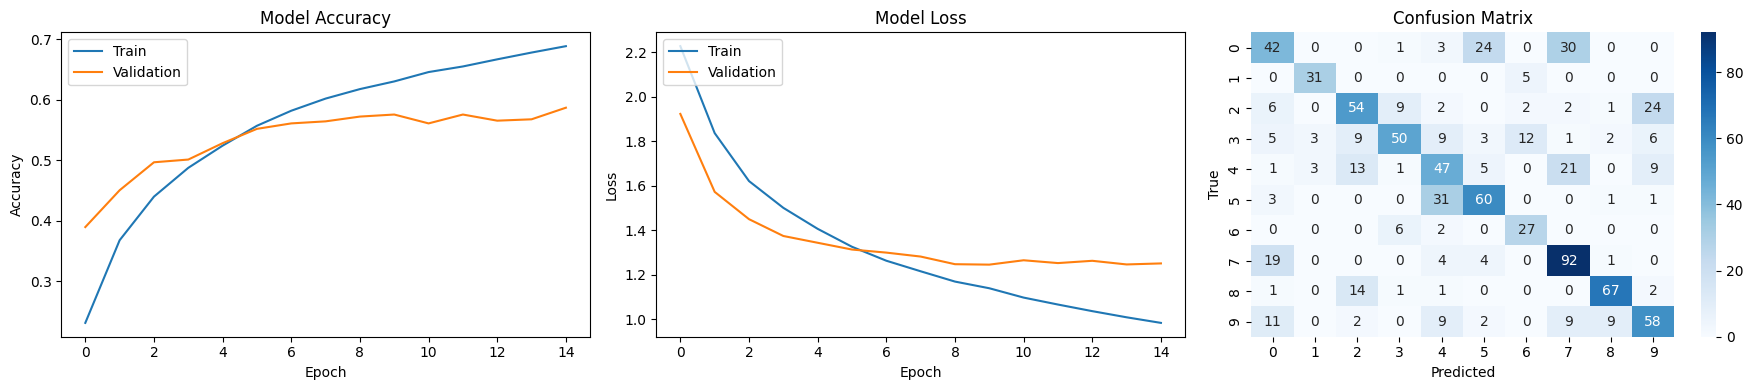

Fold 1 Test Accuracy: 0.6048


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 2...
Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.1871 - loss: 2.3275 - val_accuracy: 0.2184 - val_loss: 2.1282
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.3132 - loss: 1.9834 - val_accuracy: 0.3059 - val_loss: 1.7821
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4209 - loss: 1.6851 - val_accuracy: 0.3741 - val_loss: 1.6631
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4791 - loss: 1.5259 - val_accuracy: 0.3881 - val_loss: 1.6234
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.5218 - loss: 1.4229 - val_accuracy: 0.4443 - val_loss: 1.5788
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.5516 - loss: 1.3433 - val_accuracy: 0.4508 - val_loss: 1.5346
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.5782 - loss: 1.2815 - val_accuracy: 0.4454 - val_loss: 1.5833
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.60

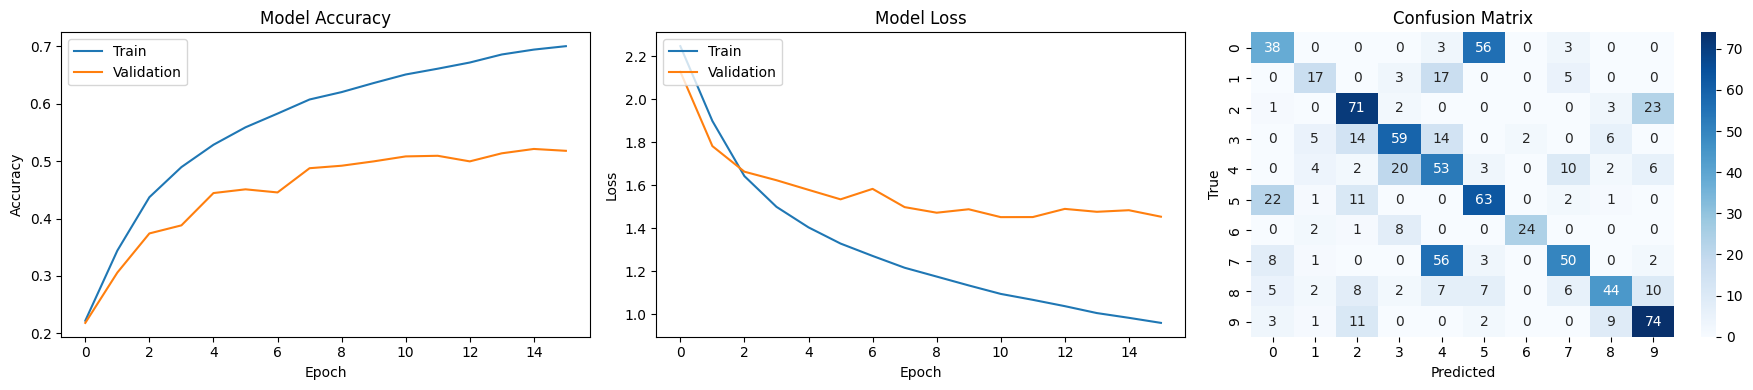

Fold 2 Test Accuracy: 0.5552


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 3...
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.1764 - loss: 2.3311 - val_accuracy: 0.2525 - val_loss: 2.0662
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.3226 - loss: 1.9593 - val_accuracy: 0.3495 - val_loss: 1.7514
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.4209 - loss: 1.6619 - val_accuracy: 0.3919 - val_loss: 1.5827
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.4861 - loss: 1.5229 - val_accuracy: 0.4455 - val_loss: 1.4965
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.5294 - loss: 1.4162 - val_accuracy: 0.4657 - val_loss: 1.4435
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.5554 - loss: 1.3481 - val_accuracy: 0.4980 - val_loss: 1.4184
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.5711 - loss: 1.2998 - val_accuracy: 0.5101 - val_loss: 1.3794
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.58

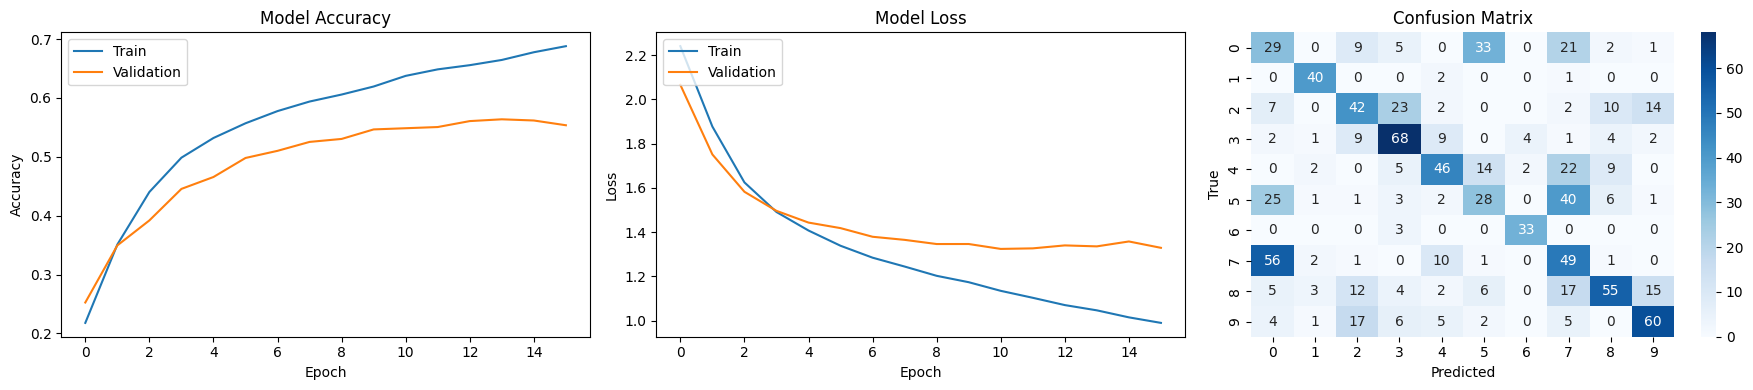

Fold 3 Test Accuracy: 0.4865


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 4...
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.1672 - loss: 2.3334 - val_accuracy: 0.2254 - val_loss: 2.1705
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.2847 - loss: 2.0315 - val_accuracy: 0.3771 - val_loss: 1.8986
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.3933 - loss: 1.7440 - val_accuracy: 0.3985 - val_loss: 1.7012
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.4579 - loss: 1.5588 - val_accuracy: 0.4092 - val_loss: 1.5937
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5100 - loss: 1.4370 - val_accuracy: 0.4348 - val_loss: 1.4884
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5447 - loss: 1.3562 - val_accuracy: 0.4594 - val_loss: 1.4488
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.5658 - loss: 1.2927 - val_accuracy: 0.4850 - val_loss: 1.4163
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.58

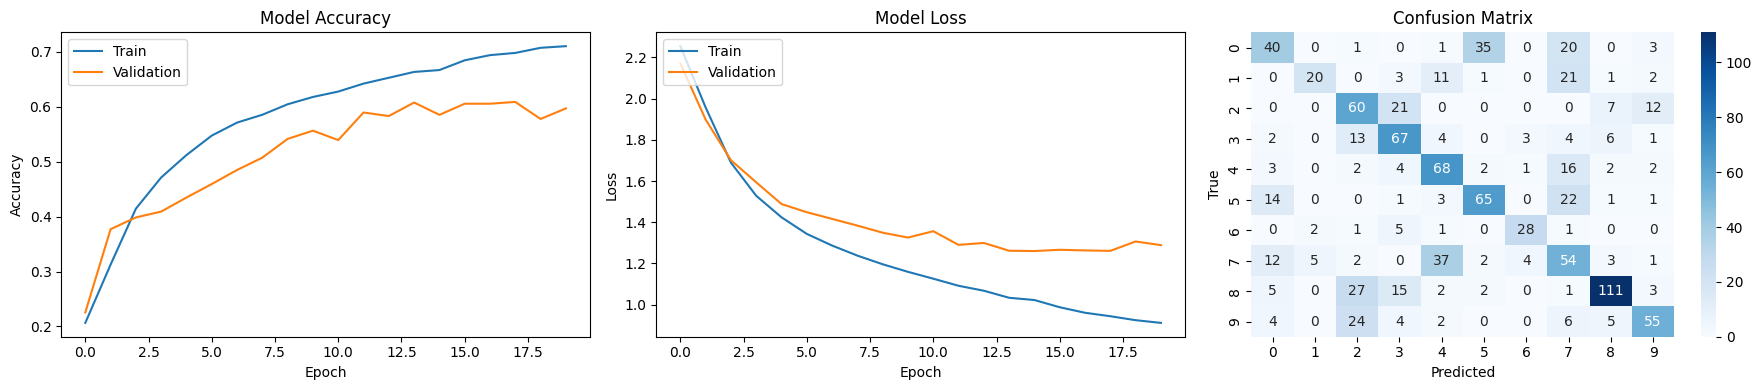

Fold 4 Test Accuracy: 0.5737


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 5...
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.1594 - loss: 2.3317 - val_accuracy: 0.3524 - val_loss: 1.9966
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.3608 - loss: 1.8788 - val_accuracy: 0.3791 - val_loss: 1.7086
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4476 - loss: 1.6125 - val_accuracy: 0.4192 - val_loss: 1.6213
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5001 - loss: 1.4758 - val_accuracy: 0.4423 - val_loss: 1.6002
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5459 - loss: 1.3828 - val_accuracy: 0.4520 - val_loss: 1.5921
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5639 - loss: 1.3250 - val_accuracy: 0.4617 - val_loss: 1.5452
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5892 - loss: 1.2667 - val_accuracy: 0.4605 - val_loss: 1.5245
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.60

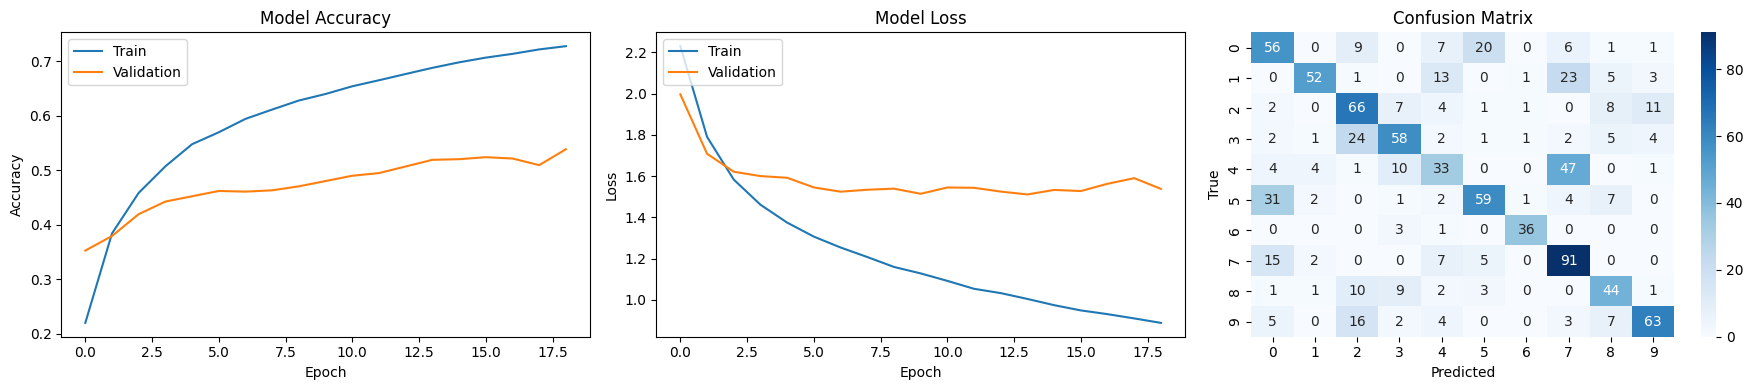

Fold 5 Test Accuracy: 0.5962


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 6...
Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.1759 - loss: 2.3301 - val_accuracy: 0.3043 - val_loss: 2.0062
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3245 - loss: 1.9665 - val_accuracy: 0.4308 - val_loss: 1.6140
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4536 - loss: 1.5945 - val_accuracy: 0.4773 - val_loss: 1.4387
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5064 - loss: 1.4565 - val_accuracy: 0.5179 - val_loss: 1.3623
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5486 - loss: 1.3582 - val_accuracy: 0.5263 - val_loss: 1.3180
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5675 - loss: 1.2954 - val_accuracy: 0.5322 - val_loss: 1.3003
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5954 - loss: 1.2370 - val_accuracy: 0.5251 - val_loss: 1.3233
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.61

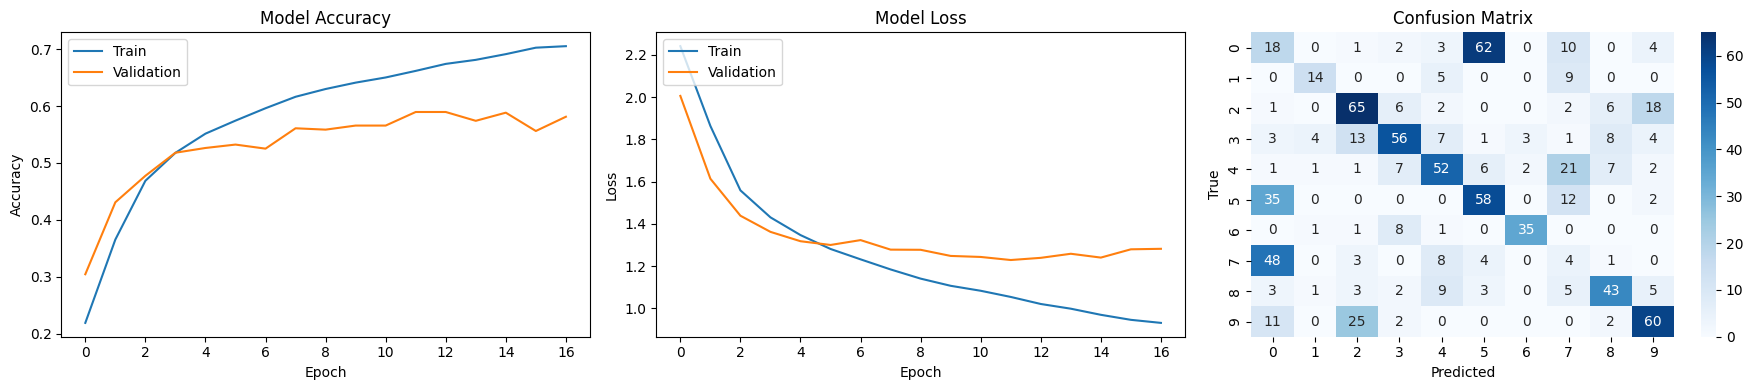

Fold 6 Test Accuracy: 0.4921


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 7...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.1993 - loss: 2.3154 - val_accuracy: 0.3412 - val_loss: 2.0137
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3389 - loss: 1.9227 - val_accuracy: 0.4529 - val_loss: 1.7457
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4157 - loss: 1.6439 - val_accuracy: 0.4864 - val_loss: 1.6048
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.4787 - loss: 1.4876 - val_accuracy: 0.4988 - val_loss: 1.5766
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5233 - loss: 1.3962 - val_accuracy: 0.4876 - val_loss: 1.5429
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5496 - loss: 1.3304 - val_accuracy: 0.5062 - val_loss: 1.5356
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5778 - loss: 1.2698 - val_accuracy: 0.4938 - val_loss: 1.5313
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.59

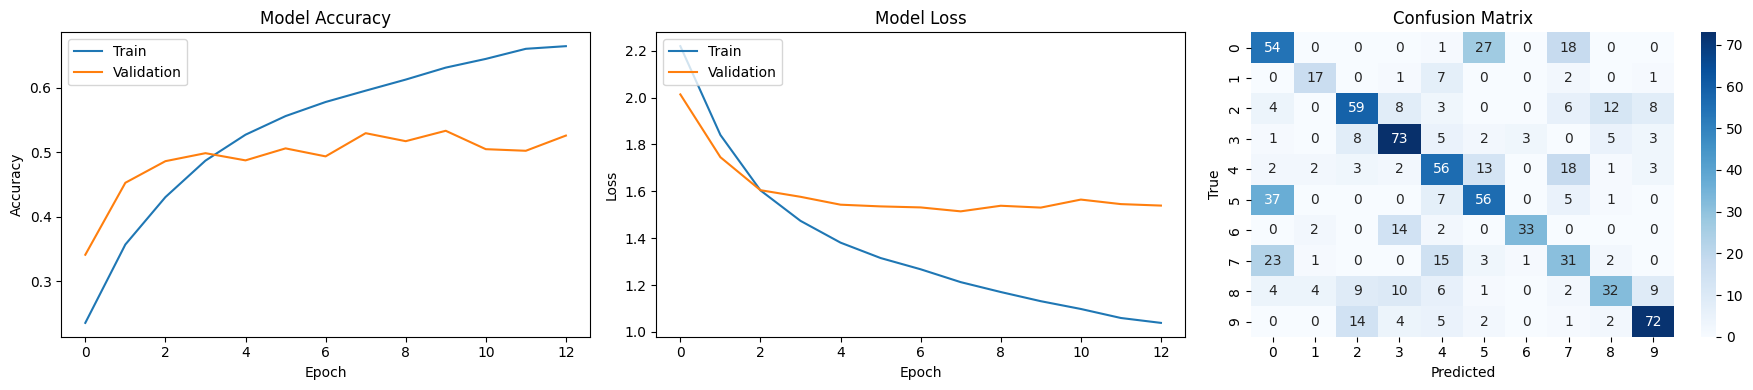

Fold 7 Test Accuracy: 0.5764


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 8...
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.1960 - loss: 2.3066 - val_accuracy: 0.1777 - val_loss: 2.1760
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3381 - loss: 1.9405 - val_accuracy: 0.3603 - val_loss: 1.8985
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.4381 - loss: 1.6084 - val_accuracy: 0.4363 - val_loss: 1.7477
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.4997 - loss: 1.4593 - val_accuracy: 0.4449 - val_loss: 1.6773
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5282 - loss: 1.3700 - val_accuracy: 0.4853 - val_loss: 1.6487
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5513 - loss: 1.3063 - val_accuracy: 0.4877 - val_loss: 1.6234
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5743 - loss: 1.2587 - val_accuracy: 0.5294 - val_loss: 1.6065
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.59

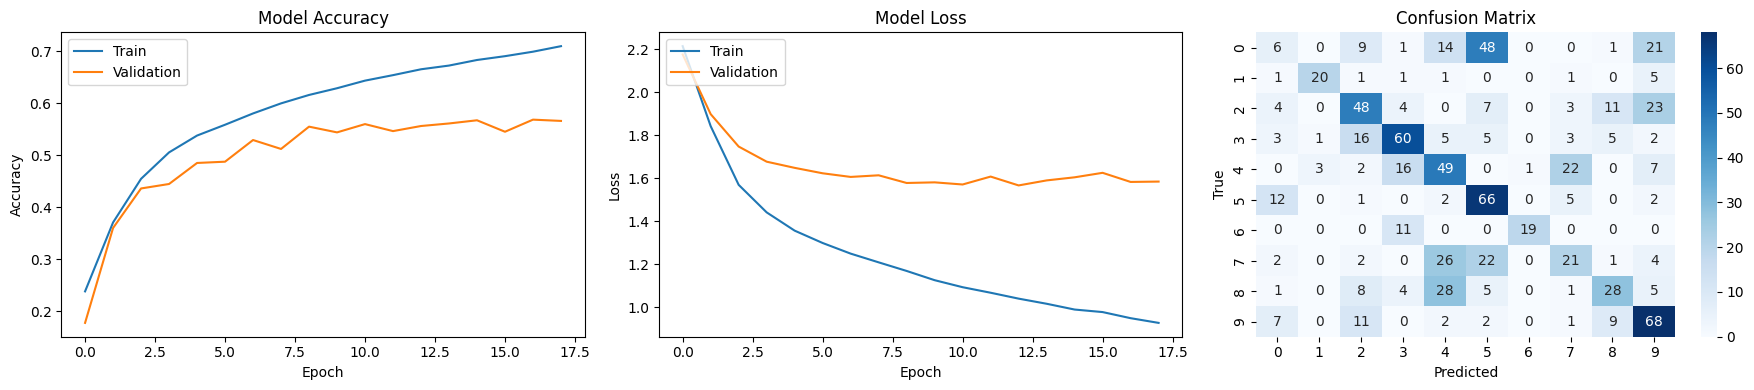

Fold 8 Test Accuracy: 0.4777


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 9...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.1757 - loss: 2.3232 - val_accuracy: 0.3811 - val_loss: 1.9871
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.3259 - loss: 1.9566 - val_accuracy: 0.4432 - val_loss: 1.6267
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.4117 - loss: 1.6722 - val_accuracy: 0.5305 - val_loss: 1.4565
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.4772 - loss: 1.5064 - val_accuracy: 0.5663 - val_loss: 1.3527
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5146 - loss: 1.4073 - val_accuracy: 0.5723 - val_loss: 1.2969
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5474 - loss: 1.3326 - val_accuracy: 0.6022 - val_loss: 1.2461
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5666 - loss: 1.2890 - val_accuracy: 0.5998 - val_loss: 1.2158
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.58

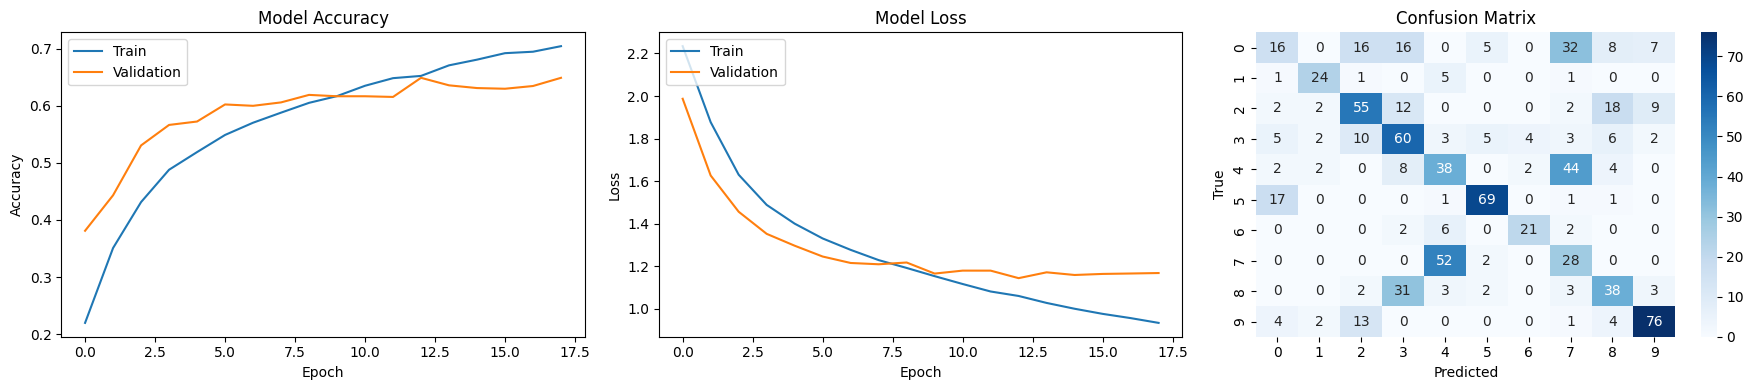

Fold 9 Test Accuracy: 0.5208


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 10...
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.1880 - loss: 2.3100 - val_accuracy: 0.3425 - val_loss: 2.0664
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.2973 - loss: 1.9941 - val_accuracy: 0.3837 - val_loss: 1.7734
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.4068 - loss: 1.7118 - val_accuracy: 0.4937 - val_loss: 1.6038
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.4763 - loss: 1.5360 - val_accuracy: 0.5029 - val_loss: 1.5852
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5181 - loss: 1.4288 - val_accuracy: 0.5338 - val_loss: 1.4738
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5436 - loss: 1.3452 - val_accuracy: 0.5670 - val_loss: 1.4040
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5712 - loss: 1.2834 - val_accuracy: 0.5590 - val_loss: 1.4134
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.5

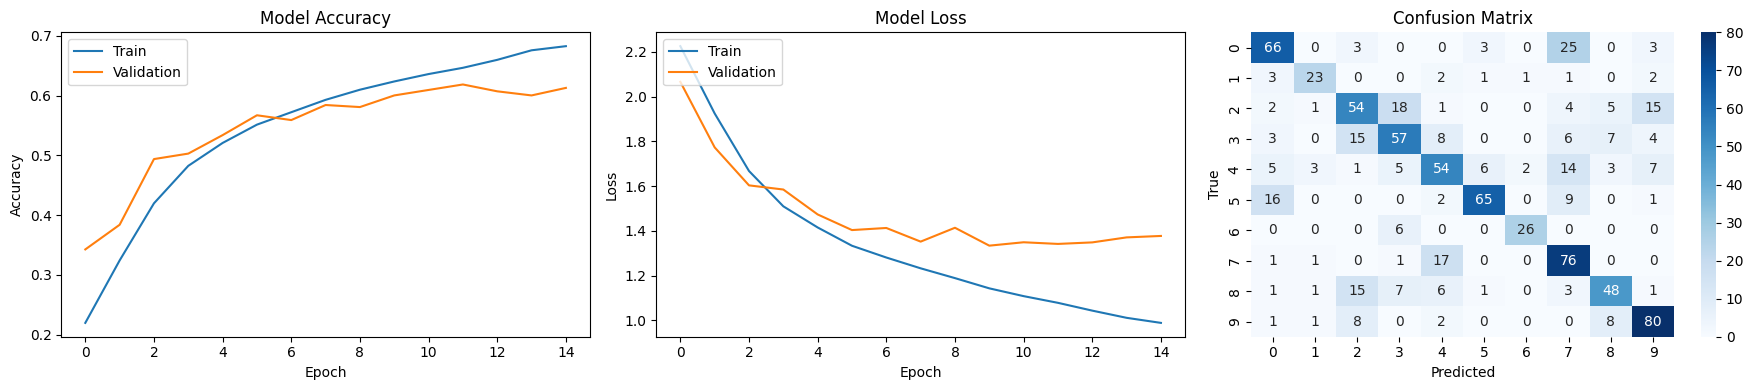

Fold 10 Test Accuracy: 0.6559

Average Accuracy across 10 folds: 55.3926%
Standard Deviation: 5.5635%


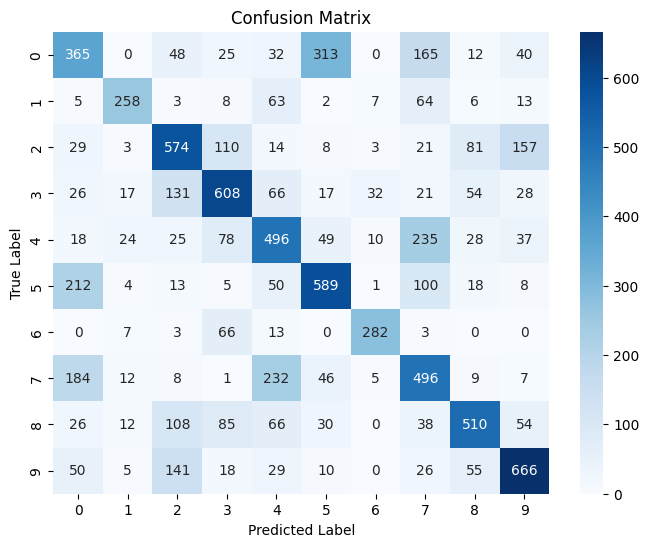

In [24]:
num_folds = 10
fold_accuracies = []
early_stoppings=[]
for i in range(num_folds):
    early_stoppings.append(EarlyStopping(
        monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
        patience=5 ,          # Number of epochs to wait after no improvement
        restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
        verbose=1            # Print messages when early stopping is triggered
    ))
    
y_test_multiclasses = []
predicted_labels_rnns = []
class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(num_folds):
    if i == i:
        # Define the test and validation indices
        test_idx = i
        val_idx = (i + 1) % num_folds
        
        # Split the data accordingly
        X_test = X_folds[test_idx]
        y_test = y_folds[test_idx]
        X_val = X_folds[val_idx]
        y_val = y_folds[val_idx]

        # Combine the remaining folds for training
        X_train = np.concatenate([X_folds_aug[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)
        y_train = np.concatenate([y_folds_aug[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)

        # Create a new model instance for each fold
        model = create_bidirectional_lstm_model()
        
        # Train the model
        print(f"\nTraining fold {i + 1}...")
        history=model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stoppings[i]])
        model.save(f"model_fold{i}.keras")

        predictions_rnn = model.predict(X_test)
        predicted_labels_rnn = np.argmax(predictions_rnn, axis=1)

        y_test_multiclass = np.argmax(y_test, axis=1)
        
        if i==0:
            y_test_multiclasses = y_test_multiclass
            predicted_labels_rnns = predicted_labels_rnn
        else:
            y_test_multiclasses = np.concatenate((y_test_multiclasses, y_test_multiclass))
            predicted_labels_rnns = np.concatenate((predicted_labels_rnns, predicted_labels_rnn))

        plot_graphs(history, y_test_multiclass, predicted_labels_rnn, class_labels=class_labels)

        # Evaluate on the test set
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Fold {i + 1} Test Accuracy: {test_acc:.4f}")
        
        # Save the accuracy for later analysis
        fold_accuracies.append(test_acc)

average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across {num_folds} folds: {average_accuracy*100:.4f}%")
print(f"Standard Deviation: {np.std(fold_accuracies)*100:.4f}%")

# Print average accuracy across all folds
cm = confusion_matrix(y_test_multiclasses, predicted_labels_rnns)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### GRU Results

c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 1...
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.2604 - loss: 2.0725 - val_accuracy: 0.5631 - val_loss: 1.2725
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.5321 - loss: 1.3649 - val_accuracy: 0.5608 - val_loss: 1.1953
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.6204 - loss: 1.1432 - val_accuracy: 0.5687 - val_loss: 1.2326
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.6794 - loss: 0.9930 - val_accuracy: 0.6363 - val_loss: 1.1809
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7335 - loss: 0.8587 - val_accuracy: 0.5743 - val_loss: 1.3855
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7600 - loss: 0.7825 - val_accuracy: 0.5991 - val_loss: 1.3020
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.7986 - loss: 0.6798 - val_accuracy: 0.5664 - val_loss: 1.5568
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.81

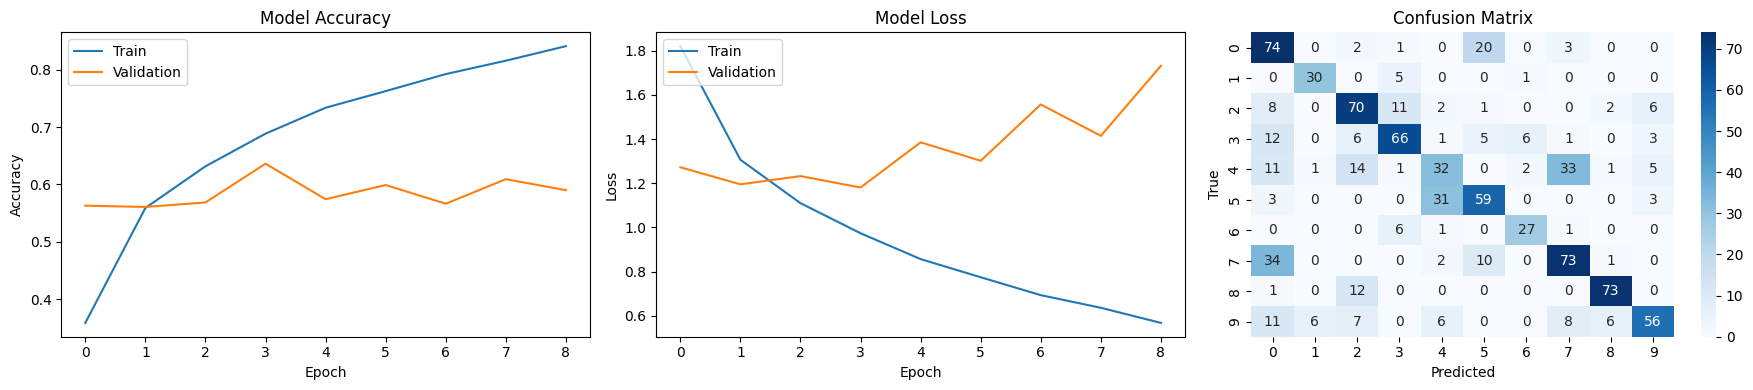

Fold 1 Test Accuracy: 0.6415


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 2...
Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.2747 - loss: 2.0583 - val_accuracy: 0.4638 - val_loss: 1.4625
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.5550 - loss: 1.3405 - val_accuracy: 0.5232 - val_loss: 1.3568
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.6440 - loss: 1.1099 - val_accuracy: 0.5881 - val_loss: 1.2684
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.7004 - loss: 0.9626 - val_accuracy: 0.5438 - val_loss: 1.4416
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.7340 - loss: 0.8722 - val_accuracy: 0.5968 - val_loss: 1.3188
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.7685 - loss: 0.7799 - val_accuracy: 0.5600 - val_loss: 1.5465
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.8007 - loss: 0.6922 - val_accuracy: 0.6065 - val_loss: 1.4386
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.82

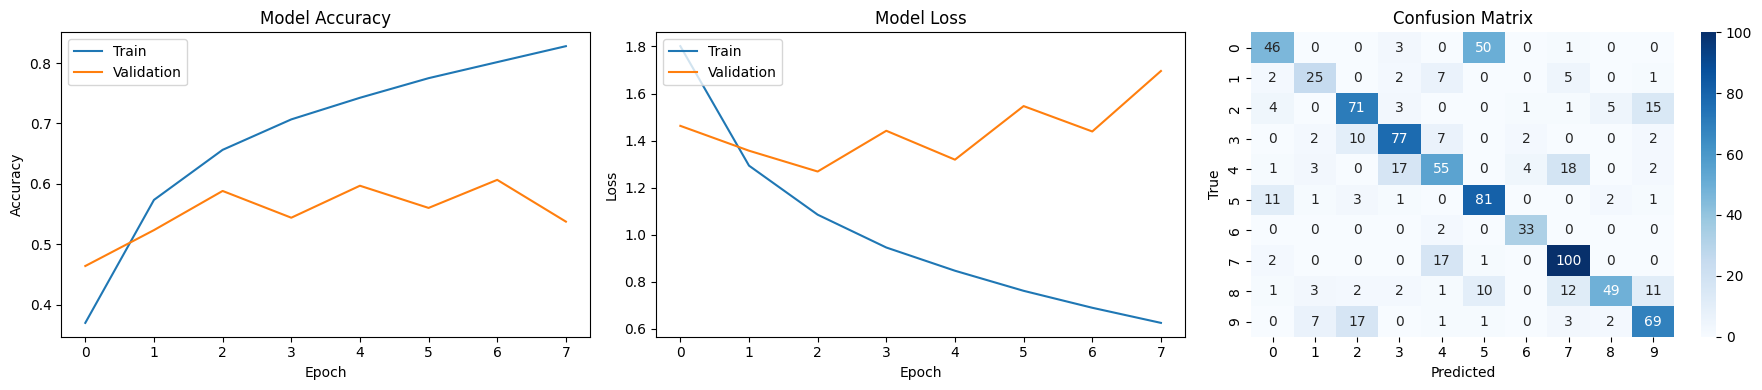

Fold 2 Test Accuracy: 0.6824


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 3...
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 55s 217ms/step - accuracy: 0.2774 - loss: 2.0446 - val_accuracy: 0.5152 - val_loss: 1.4067
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 45s 212ms/step - accuracy: 0.5218 - loss: 1.4019 - val_accuracy: 0.5869 - val_loss: 1.2523
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 46s 213ms/step - accuracy: 0.6202 - loss: 1.1749 - val_accuracy: 0.5949 - val_loss: 1.2143
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 45s 210ms/step - accuracy: 0.6795 - loss: 1.0104 - val_accuracy: 0.6192 - val_loss: 1.2111
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 45s 211ms/step - accuracy: 0.7191 - loss: 0.9100 - val_accuracy: 0.5980 - val_loss: 1.3475
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 46s 214ms/step - accuracy: 0.7521 - loss: 0.8279 - val_accuracy: 0.6434 - val_loss: 1.2437
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.7839 - loss: 0.7378 - val_accuracy: 0.6566 - val_loss: 1.2164
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 45s 209ms/step - accura

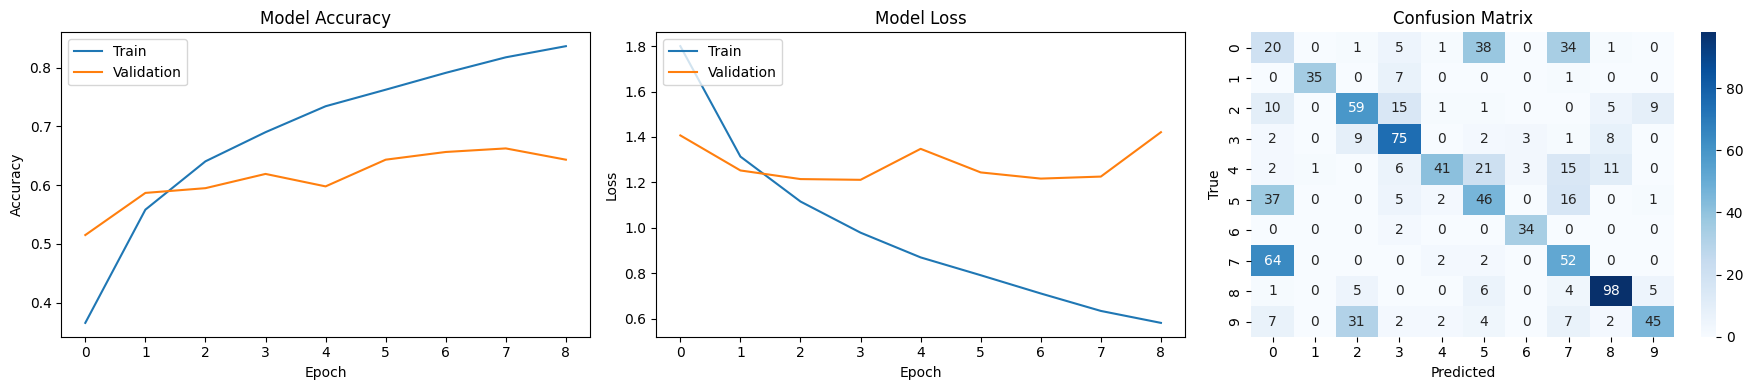

Fold 3 Test Accuracy: 0.5459


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 4...
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 50s 194ms/step - accuracy: 0.2763 - loss: 2.0596 - val_accuracy: 0.4348 - val_loss: 1.4598
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.5291 - loss: 1.3823 - val_accuracy: 0.5705 - val_loss: 1.1909
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.6316 - loss: 1.1380 - val_accuracy: 0.6047 - val_loss: 1.1589
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - accuracy: 0.6806 - loss: 0.9953 - val_accuracy: 0.6058 - val_loss: 1.1300
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.7240 - loss: 0.8895 - val_accuracy: 0.6346 - val_loss: 1.1178
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.7639 - loss: 0.7812 - val_accuracy: 0.6250 - val_loss: 1.2604
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.7928 - loss: 0.6986 - val_accuracy: 0.6090 - val_loss: 1.3236
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - accura

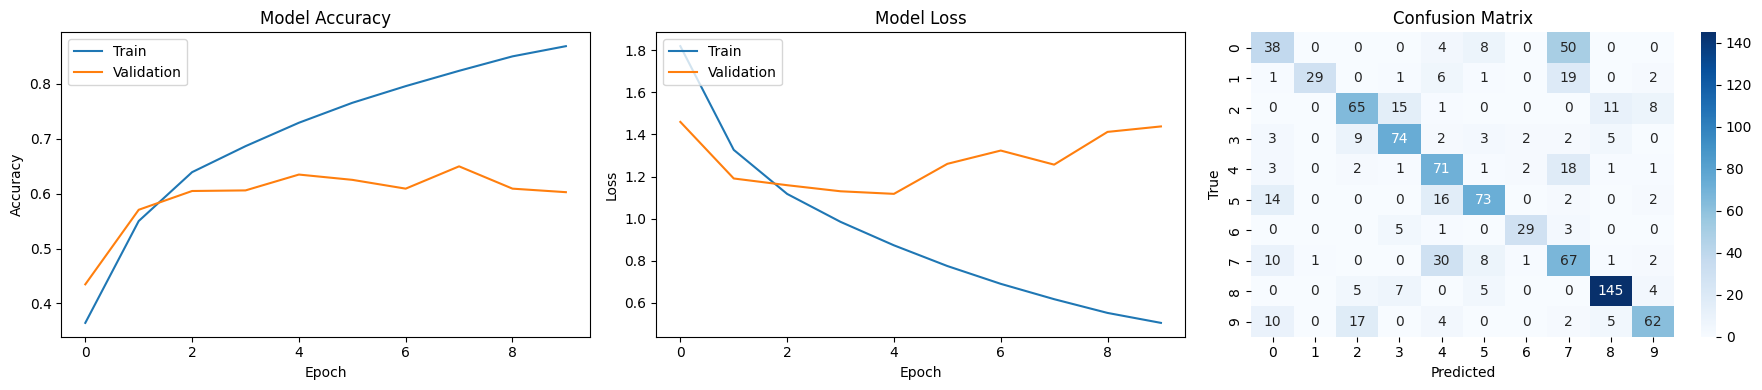

Fold 4 Test Accuracy: 0.6596


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 5...
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 48s 179ms/step - accuracy: 0.2801 - loss: 2.0508 - val_accuracy: 0.4860 - val_loss: 1.4767
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step - accuracy: 0.5477 - loss: 1.3442 - val_accuracy: 0.5103 - val_loss: 1.4279
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.6397 - loss: 1.1098 - val_accuracy: 0.5650 - val_loss: 1.4260
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 39s 179ms/step - accuracy: 0.6923 - loss: 0.9719 - val_accuracy: 0.5759 - val_loss: 1.3841
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step - accuracy: 0.7441 - loss: 0.8489 - val_accuracy: 0.5735 - val_loss: 1.4934
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accuracy: 0.7741 - loss: 0.7514 - val_accuracy: 0.5917 - val_loss: 1.4633
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - accuracy: 0.8057 - loss: 0.6813 - val_accuracy: 0.6075 - val_loss: 1.5852
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accura

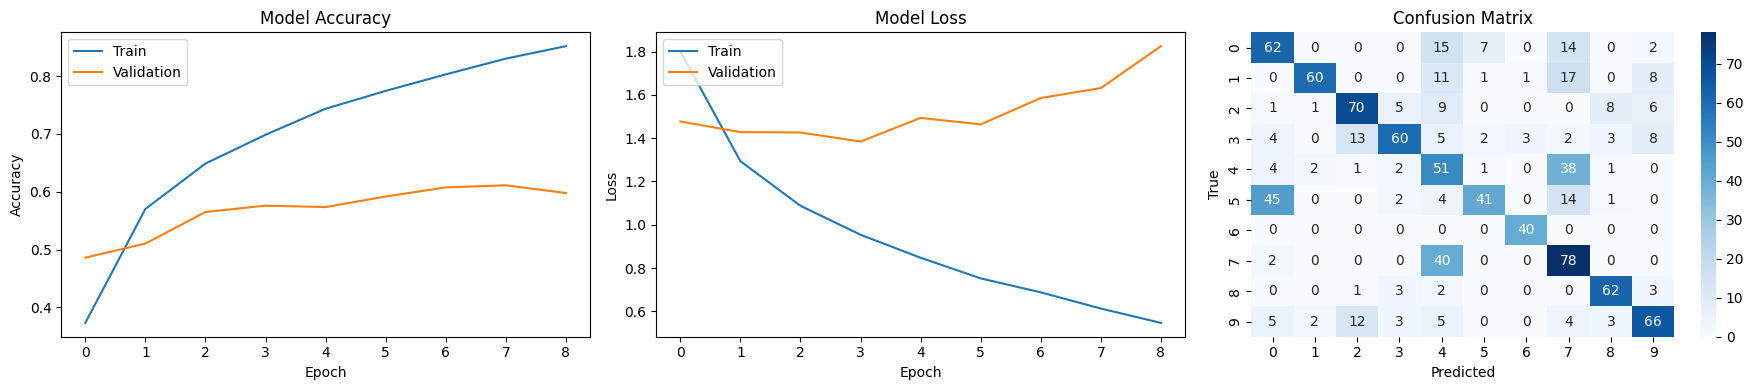

Fold 5 Test Accuracy: 0.6303


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 6...
Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 61s 237ms/step - accuracy: 0.2796 - loss: 2.0518 - val_accuracy: 0.5155 - val_loss: 1.2949
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 50s 227ms/step - accuracy: 0.5477 - loss: 1.3405 - val_accuracy: 0.5883 - val_loss: 1.2412
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 51s 231ms/step - accuracy: 0.6443 - loss: 1.1158 - val_accuracy: 0.5871 - val_loss: 1.2495
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 52s 235ms/step - accuracy: 0.6925 - loss: 0.9709 - val_accuracy: 0.6205 - val_loss: 1.2388
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 51s 233ms/step - accuracy: 0.7403 - loss: 0.8472 - val_accuracy: 0.6241 - val_loss: 1.3016
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 52s 234ms/step - accuracy: 0.7715 - loss: 0.7576 - val_accuracy: 0.6169 - val_loss: 1.3644
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 51s 230ms/step - accuracy: 0.8001 - loss: 0.6794 - val_accuracy: 0.6468 - val_loss: 1.3766
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 51s 231ms/step - accura

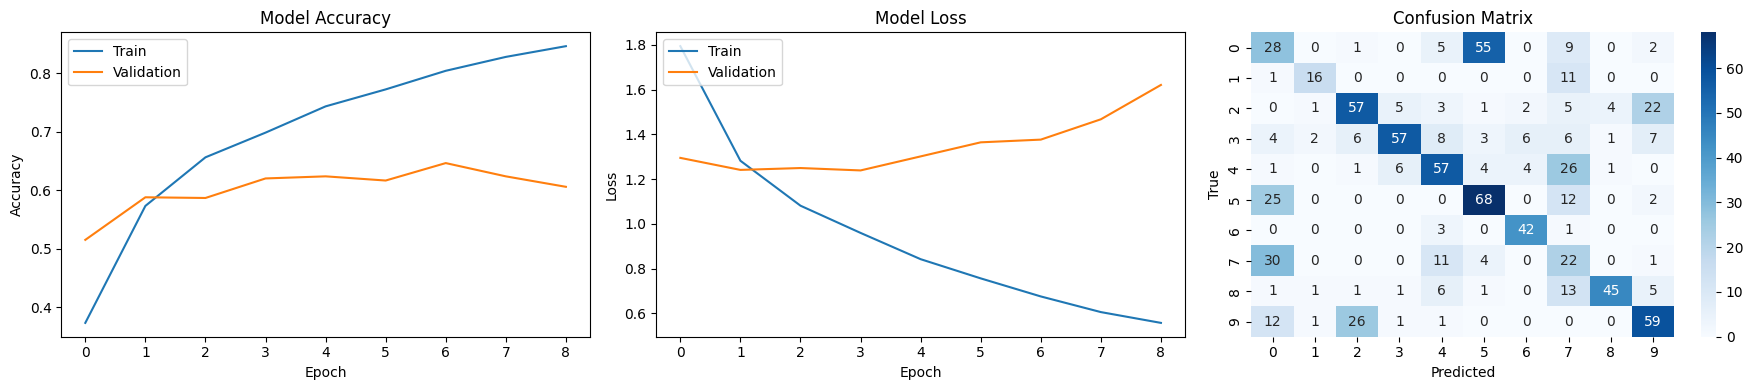

Fold 6 Test Accuracy: 0.5480


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 7...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 67s 264ms/step - accuracy: 0.2719 - loss: 2.0627 - val_accuracy: 0.5099 - val_loss: 1.4704
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 56s 250ms/step - accuracy: 0.5383 - loss: 1.3493 - val_accuracy: 0.6377 - val_loss: 1.2682
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 56s 254ms/step - accuracy: 0.6290 - loss: 1.1348 - val_accuracy: 0.6365 - val_loss: 1.2306
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 56s 253ms/step - accuracy: 0.6891 - loss: 0.9746 - val_accuracy: 0.6663 - val_loss: 1.2526
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 56s 251ms/step - accuracy: 0.7356 - loss: 0.8603 - val_accuracy: 0.6687 - val_loss: 1.2493
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 57s 255ms/step - accuracy: 0.7745 - loss: 0.7542 - val_accuracy: 0.6427 - val_loss: 1.3695
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 259ms/step - accuracy: 0.8004 - loss: 0.6740 - val_accuracy: 0.6365 - val_loss: 1.4357
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 57s 256ms/step - accura

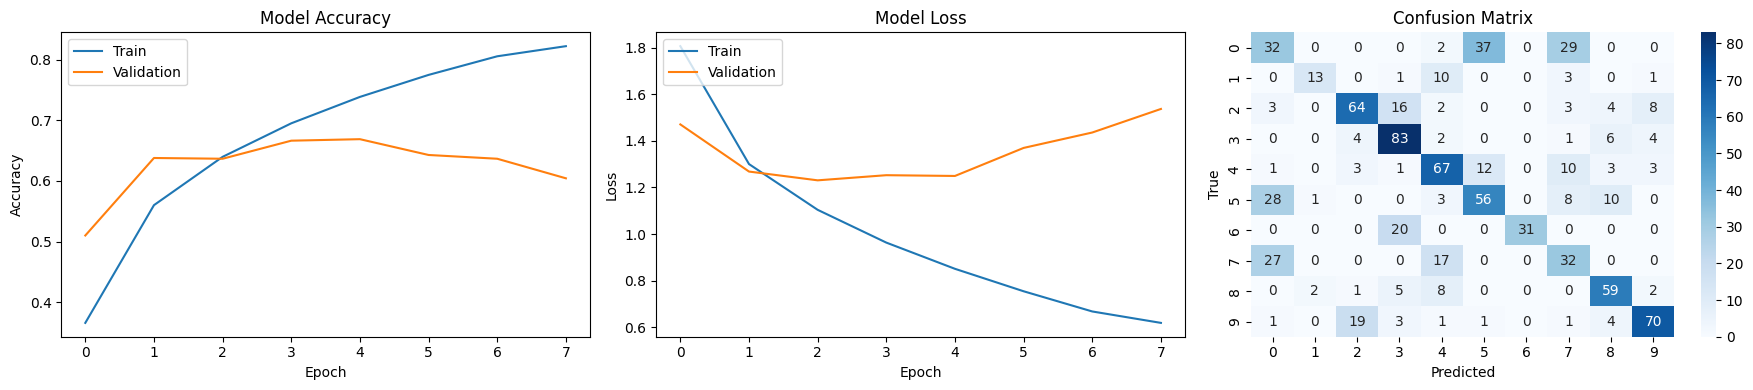

Fold 7 Test Accuracy: 0.6050


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 8...
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 66s 253ms/step - accuracy: 0.2712 - loss: 2.0685 - val_accuracy: 0.4804 - val_loss: 1.4645
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - accuracy: 0.5390 - loss: 1.3478 - val_accuracy: 0.5870 - val_loss: 1.3551
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 53s 237ms/step - accuracy: 0.6214 - loss: 1.1284 - val_accuracy: 0.6091 - val_loss: 1.3120
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 54s 242ms/step - accuracy: 0.6876 - loss: 0.9639 - val_accuracy: 0.6140 - val_loss: 1.3118
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 54s 244ms/step - accuracy: 0.7385 - loss: 0.8449 - val_accuracy: 0.6826 - val_loss: 1.2297
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 55s 245ms/step - accuracy: 0.7737 - loss: 0.7584 - val_accuracy: 0.6777 - val_loss: 1.2484
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - accuracy: 0.8009 - loss: 0.6866 - val_accuracy: 0.6691 - val_loss: 1.3124
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 53s 240ms/step - accura

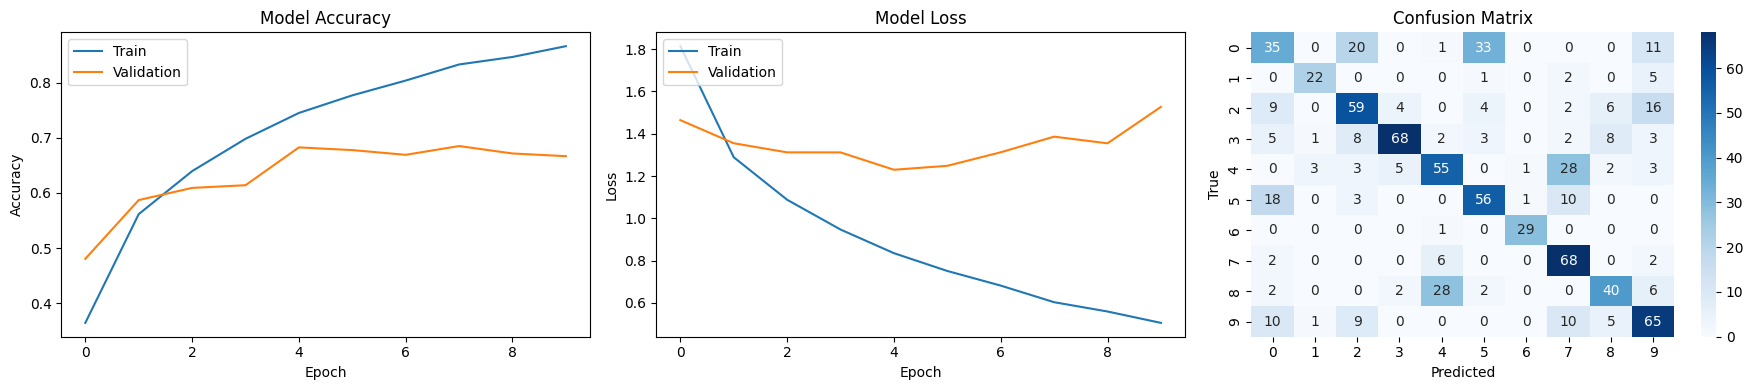

Fold 8 Test Accuracy: 0.6166


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 9...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 66s 255ms/step - accuracy: 0.2765 - loss: 2.0727 - val_accuracy: 0.5532 - val_loss: 1.3302
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 53s 239ms/step - accuracy: 0.5420 - loss: 1.3534 - val_accuracy: 0.6141 - val_loss: 1.1991
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 55s 247ms/step - accuracy: 0.6261 - loss: 1.1297 - val_accuracy: 0.6428 - val_loss: 1.1287
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 55s 246ms/step - accuracy: 0.6742 - loss: 0.9844 - val_accuracy: 0.6308 - val_loss: 1.1546
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 55s 248ms/step - accuracy: 0.7254 - loss: 0.8602 - val_accuracy: 0.6655 - val_loss: 1.2383
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 55s 248ms/step - accuracy: 0.7585 - loss: 0.7841 - val_accuracy: 0.6714 - val_loss: 1.2630
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 53s 239ms/step - accuracy: 0.7906 - loss: 0.7020 - val_accuracy: 0.6464 - val_loss: 1.3233
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 55s 246ms/step - accura

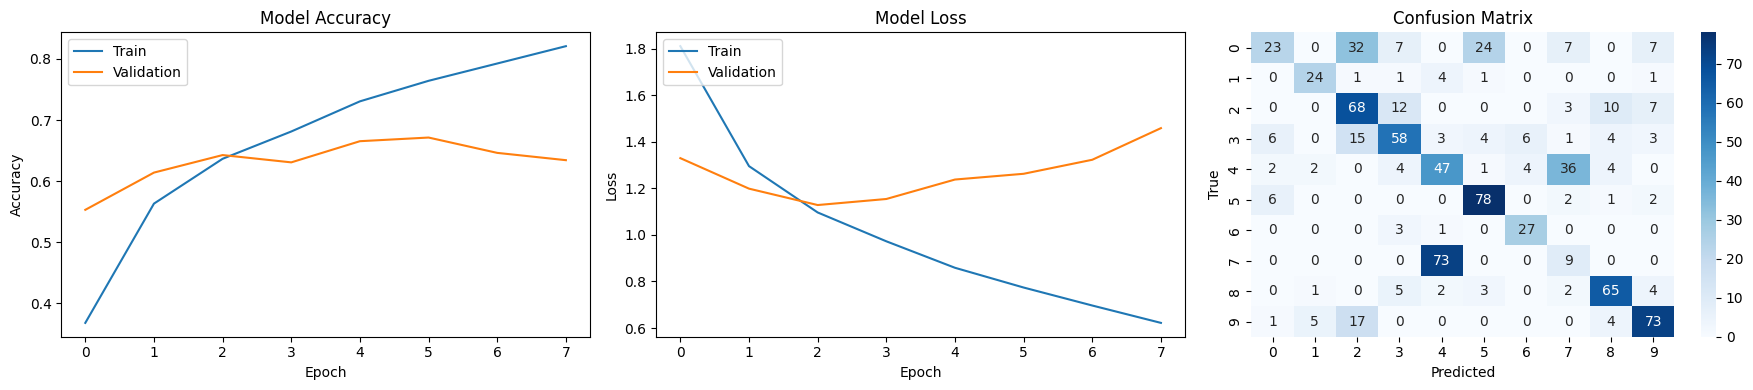

Fold 9 Test Accuracy: 0.5784


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 10...
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 247ms/step - accuracy: 0.2583 - loss: 2.0748 - val_accuracy: 0.4994 - val_loss: 1.5028
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 53s 242ms/step - accuracy: 0.5340 - loss: 1.3630 - val_accuracy: 0.5727 - val_loss: 1.4110
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 54s 245ms/step - accuracy: 0.6170 - loss: 1.1353 - val_accuracy: 0.6266 - val_loss: 1.2586
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 55s 248ms/step - accuracy: 0.6820 - loss: 0.9792 - val_accuracy: 0.6403 - val_loss: 1.3174
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 54s 246ms/step - accuracy: 0.7238 - loss: 0.8766 - val_accuracy: 0.6678 - val_loss: 1.1729
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 54s 245ms/step - accuracy: 0.7597 - loss: 0.7813 - val_accuracy: 0.6312 - val_loss: 1.2873
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 53s 243ms/step - accuracy: 0.7956 - loss: 0.6850 - val_accuracy: 0.6140 - val_loss: 1.4318
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 54s 244ms/step - accur

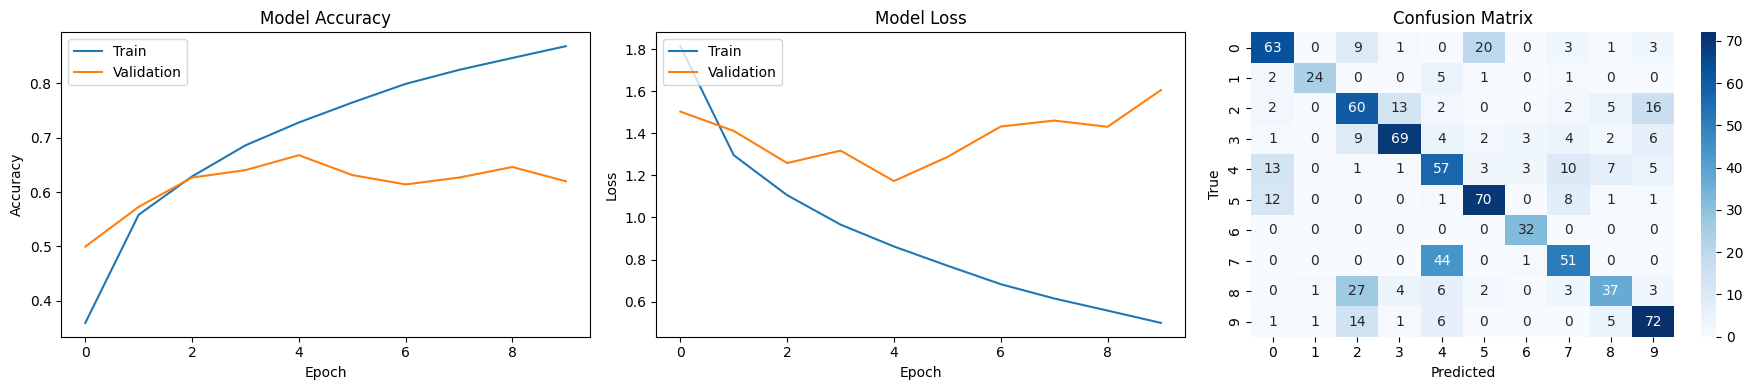

Fold 10 Test Accuracy: 0.6392

Average Accuracy across 10 folds: 61.4703%
Standard Deviation: 4.3306%


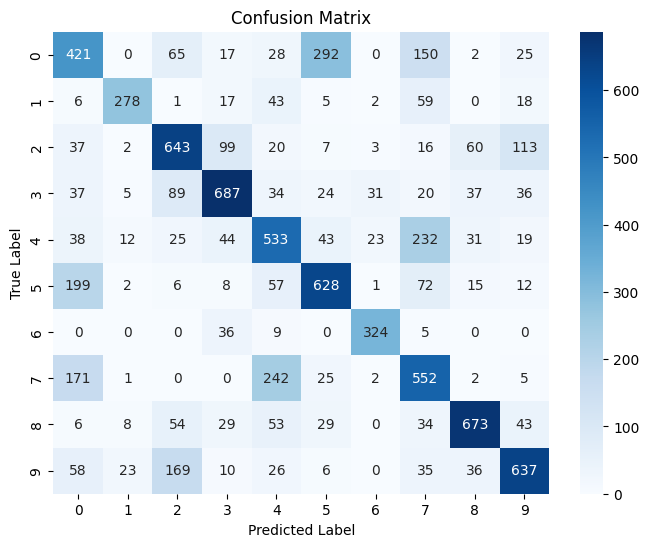

In [25]:
num_folds = 10
fold_accuracies = []
early_stoppings=[]
for i in range(num_folds):
    early_stoppings.append(EarlyStopping(
        monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
        patience=5 ,          # Number of epochs to wait after no improvement
        restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
        verbose=1            # Print messages when early stopping is triggered
    ))
    
y_test_multiclasses = []
predicted_labels_rnns = []
class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(num_folds):
    if i == i:
        # Define the test and validation indices
        test_idx = i
        val_idx = (i + 1) % num_folds
        
        # Split the data accordingly
        X_test = X_folds[test_idx]
        y_test = y_folds[test_idx]
        X_val = X_folds[val_idx]
        y_val = y_folds[val_idx]

        # Combine the remaining folds for training
        X_train = np.concatenate([X_folds_aug[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)
        y_train = np.concatenate([y_folds_aug[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)

        # Create a new model instance for each fold
        model = create_bidirectional_GRU_model()
        
        # Train the model
        print(f"\nTraining fold {i + 1}...")
        history=model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stoppings[i]])
        model.save(f"model_fold{i}.keras")

        predictions_rnn = model.predict(X_test)
        predicted_labels_rnn = np.argmax(predictions_rnn, axis=1)

        y_test_multiclass = np.argmax(y_test, axis=1)
        
        if i==0:
            y_test_multiclasses = y_test_multiclass
            predicted_labels_rnns = predicted_labels_rnn
        else:
            y_test_multiclasses = np.concatenate((y_test_multiclasses, y_test_multiclass))
            predicted_labels_rnns = np.concatenate((predicted_labels_rnns, predicted_labels_rnn))

        plot_graphs(history, y_test_multiclass, predicted_labels_rnn, class_labels=class_labels)

        # Evaluate on the test set
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Fold {i + 1} Test Accuracy: {test_acc:.4f}")
        
        # Save the accuracy for later analysis
        fold_accuracies.append(test_acc)

average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across {num_folds} folds: {average_accuracy*100:.4f}%")
print(f"Standard Deviation: {np.std(fold_accuracies)*100:.4f}%")

# Print average accuracy across all folds
cm = confusion_matrix(y_test_multiclasses, predicted_labels_rnns)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Vanilla RNN Results

c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 1...
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.1326 - loss: 2.4460 - val_accuracy: 0.2038 - val_loss: 2.1324
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.2021 - loss: 2.1973 - val_accuracy: 0.2095 - val_loss: 2.0673
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.2298 - loss: 2.1133 - val_accuracy: 0.2500 - val_loss: 2.0102
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.2624 - loss: 2.0476 - val_accuracy: 0.3018 - val_loss: 1.9549
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.2995 - loss: 1.9423 - val_accuracy: 0.3457 - val_loss: 1.7375
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.3412 - loss: 1.7954 - val_accuracy: 0.3502 - val_loss: 1.7627
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.3736 - loss: 1.6919 - val_accuracy: 0.3502 - val_loss: 1.7413
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.39

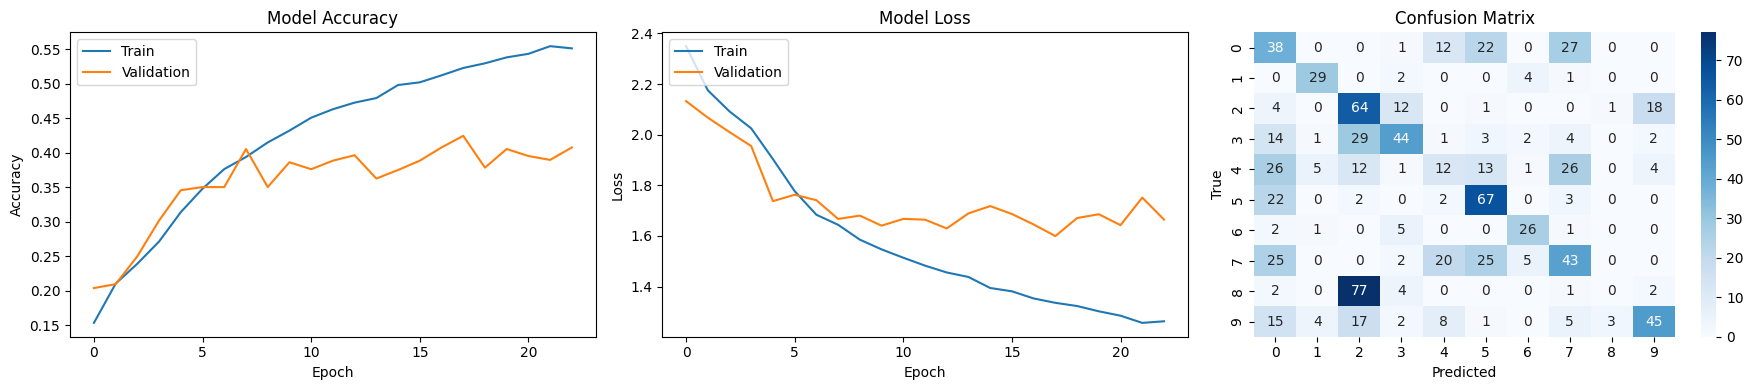

Fold 1 Test Accuracy: 0.4215


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 2...
Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.1321 - loss: 2.4213 - val_accuracy: 0.1838 - val_loss: 2.1464
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.2026 - loss: 2.1865 - val_accuracy: 0.2032 - val_loss: 2.0805
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.2395 - loss: 2.0898 - val_accuracy: 0.2346 - val_loss: 2.0301
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.2791 - loss: 1.9897 - val_accuracy: 0.2854 - val_loss: 1.8323
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.3176 - loss: 1.8402 - val_accuracy: 0.2876 - val_loss: 1.8122
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.3429 - loss: 1.7480 - val_accuracy: 0.3178 - val_loss: 1.6711
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.3744 - loss: 1.6632 - val_accuracy: 0.2995 - val_loss: 1.8313
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.38

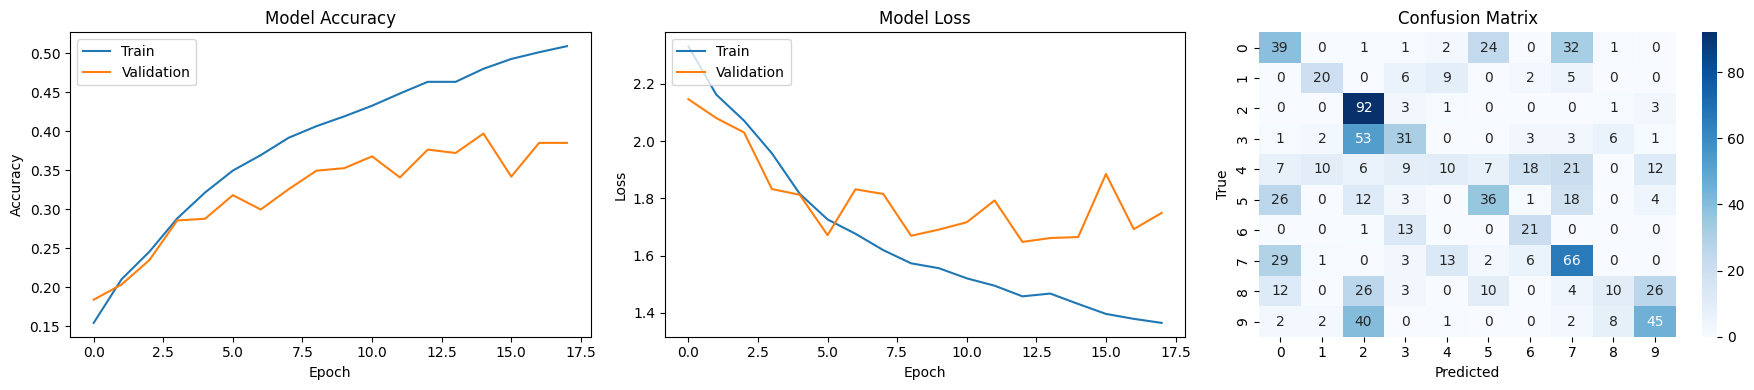

Fold 2 Test Accuracy: 0.4167


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 3...
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.1427 - loss: 2.4462 - val_accuracy: 0.2101 - val_loss: 2.1306
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.1935 - loss: 2.1758 - val_accuracy: 0.2414 - val_loss: 2.0662
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.2283 - loss: 2.0896 - val_accuracy: 0.2697 - val_loss: 2.0530
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.2629 - loss: 2.0139 - val_accuracy: 0.2960 - val_loss: 2.0086
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.2898 - loss: 1.9594 - val_accuracy: 0.3121 - val_loss: 1.8093
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.3391 - loss: 1.8096 - val_accuracy: 0.3606 - val_loss: 1.7297
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.3507 - loss: 1.7740 - val_accuracy: 0.3606 - val_loss: 1.6633
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.38

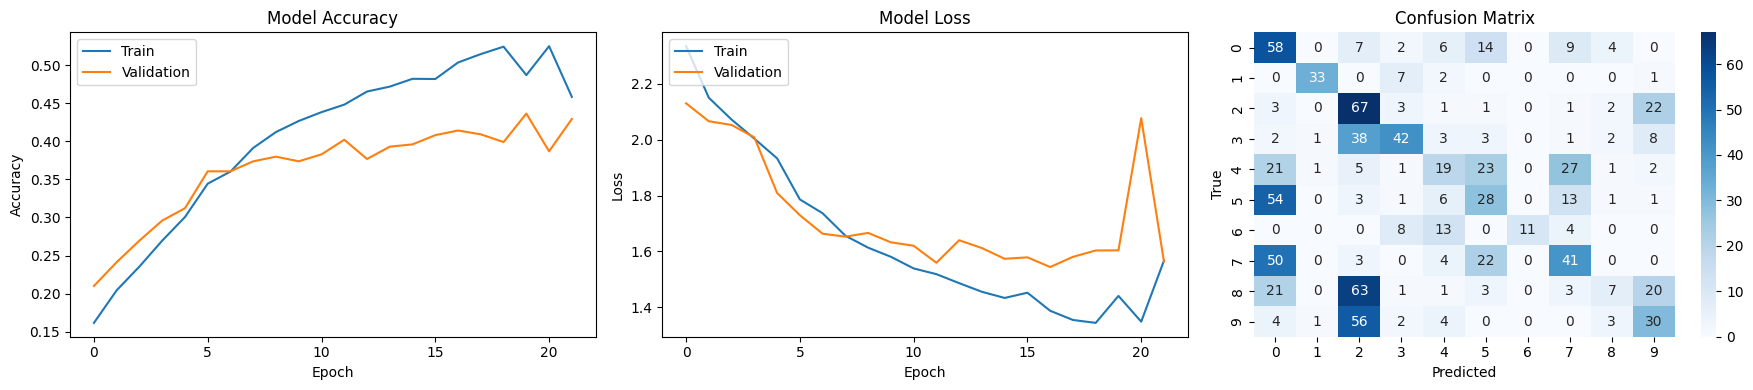

Fold 3 Test Accuracy: 0.3632


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 4...
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.1363 - loss: 2.4266 - val_accuracy: 0.2158 - val_loss: 2.1344
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.2056 - loss: 2.1683 - val_accuracy: 0.2553 - val_loss: 2.0429
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.2328 - loss: 2.0827 - val_accuracy: 0.3312 - val_loss: 1.9443
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.2565 - loss: 2.0264 - val_accuracy: 0.3098 - val_loss: 1.9293
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.2941 - loss: 1.9591 - val_accuracy: 0.3526 - val_loss: 1.8274
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.3253 - loss: 1.8667 - val_accuracy: 0.3761 - val_loss: 1.7466
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.3622 - loss: 1.7539 - val_accuracy: 0.4209 - val_loss: 1.6152
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.38

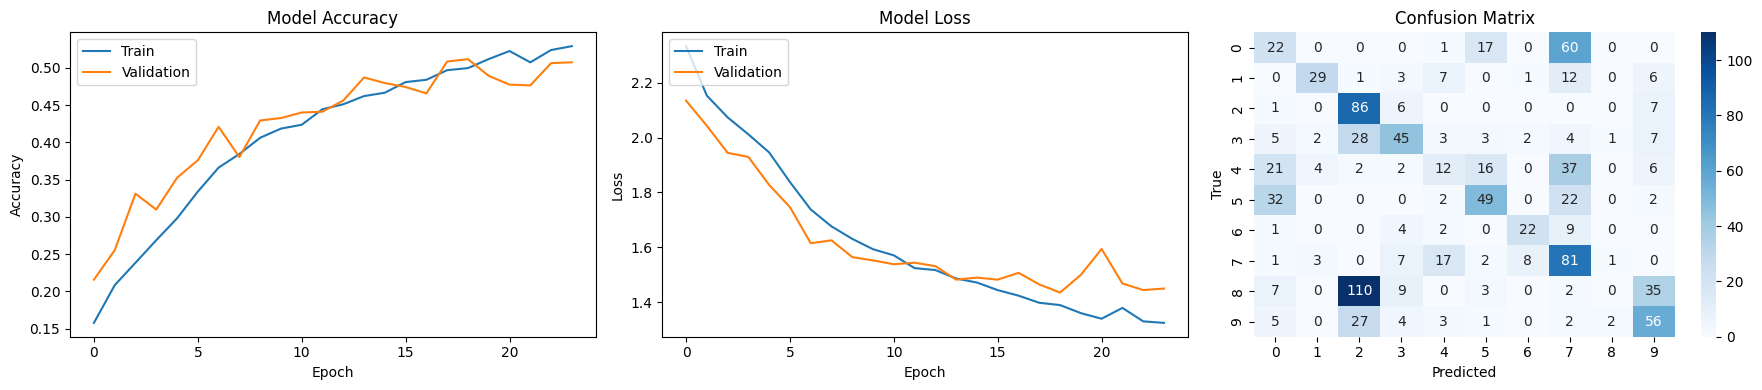

Fold 4 Test Accuracy: 0.4061


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 5...
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.1444 - loss: 2.4043 - val_accuracy: 0.2017 - val_loss: 2.1472
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.2040 - loss: 2.1737 - val_accuracy: 0.2139 - val_loss: 2.1088
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.2376 - loss: 2.0801 - val_accuracy: 0.2309 - val_loss: 2.0975
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.2741 - loss: 1.9992 - val_accuracy: 0.2515 - val_loss: 1.9259
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.3273 - loss: 1.8326 - val_accuracy: 0.2527 - val_loss: 1.8390
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.3498 - loss: 1.7347 - val_accuracy: 0.2770 - val_loss: 1.8168
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.3710 - loss: 1.6787 - val_accuracy: 0.2831 - val_loss: 1.8753
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.37

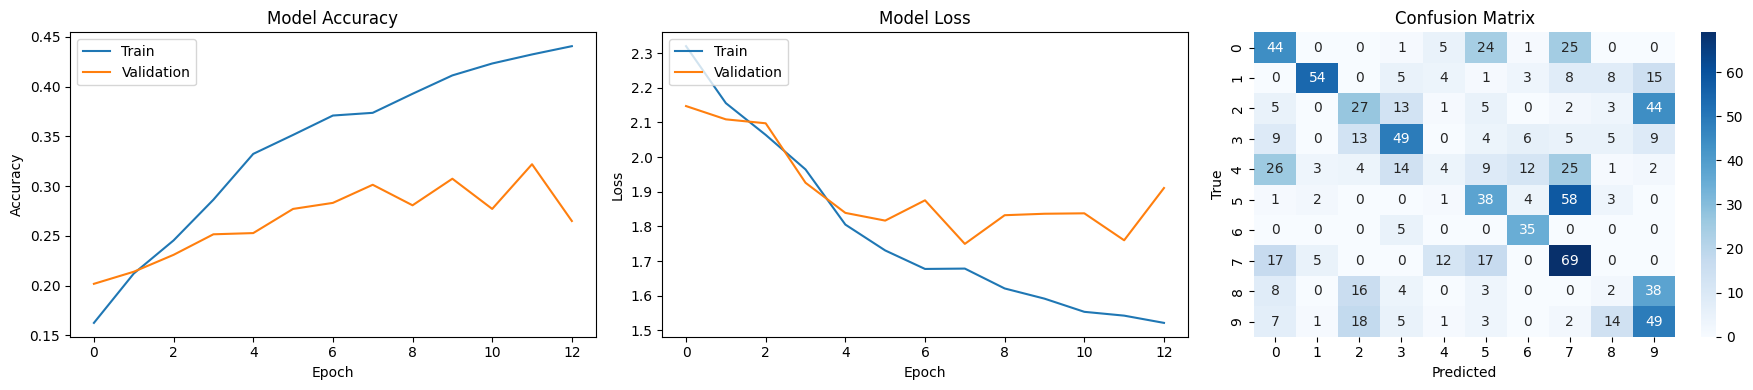

Fold 5 Test Accuracy: 0.3964


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 6...
Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.1376 - loss: 2.4316 - val_accuracy: 0.2363 - val_loss: 2.1009
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.2184 - loss: 2.1549 - val_accuracy: 0.2649 - val_loss: 2.0013
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.2562 - loss: 2.0479 - val_accuracy: 0.3258 - val_loss: 1.8697
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.3100 - loss: 1.9030 - val_accuracy: 0.3604 - val_loss: 1.7733
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.3502 - loss: 1.7672 - val_accuracy: 0.3604 - val_loss: 1.7835
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.3626 - loss: 1.7076 - val_accuracy: 0.3473 - val_loss: 1.7085
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.3826 - loss: 1.6497 - val_accuracy: 0.3974 - val_loss: 1.6683
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.40

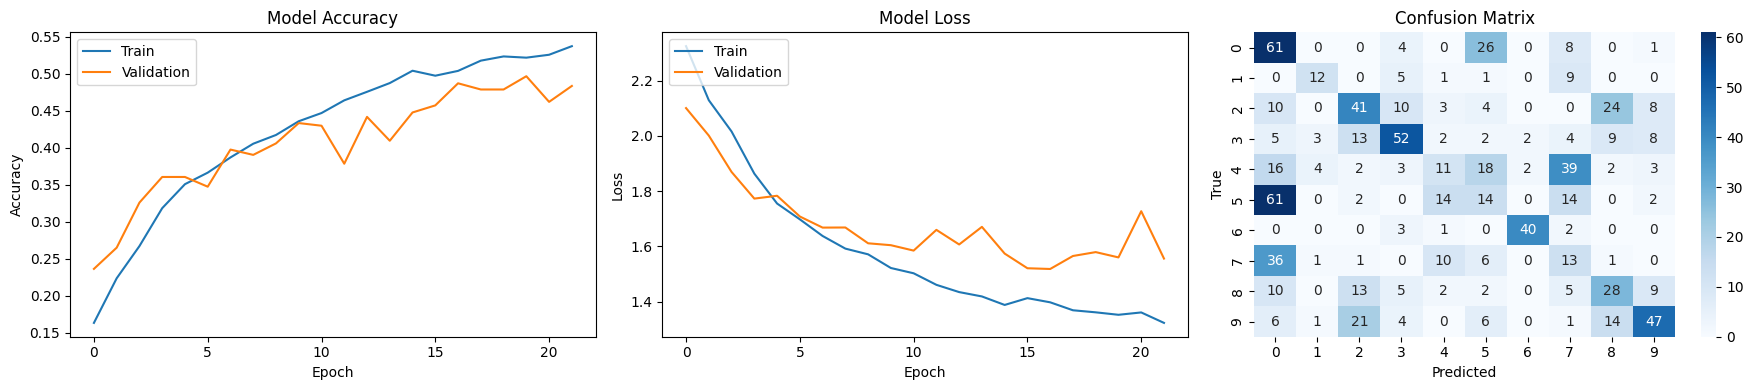

Fold 6 Test Accuracy: 0.3876


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 7...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.1364 - loss: 2.4178 - val_accuracy: 0.2643 - val_loss: 2.0616
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.1976 - loss: 2.1755 - val_accuracy: 0.2543 - val_loss: 1.9896
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.2314 - loss: 2.0873 - val_accuracy: 0.2792 - val_loss: 1.9197
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.2594 - loss: 2.0198 - val_accuracy: 0.2854 - val_loss: 1.9001
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.2913 - loss: 1.9208 - val_accuracy: 0.3685 - val_loss: 1.8588
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.3391 - loss: 1.7541 - val_accuracy: 0.4045 - val_loss: 1.7670
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.3722 - loss: 1.6642 - val_accuracy: 0.3970 - val_loss: 1.8083
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.38

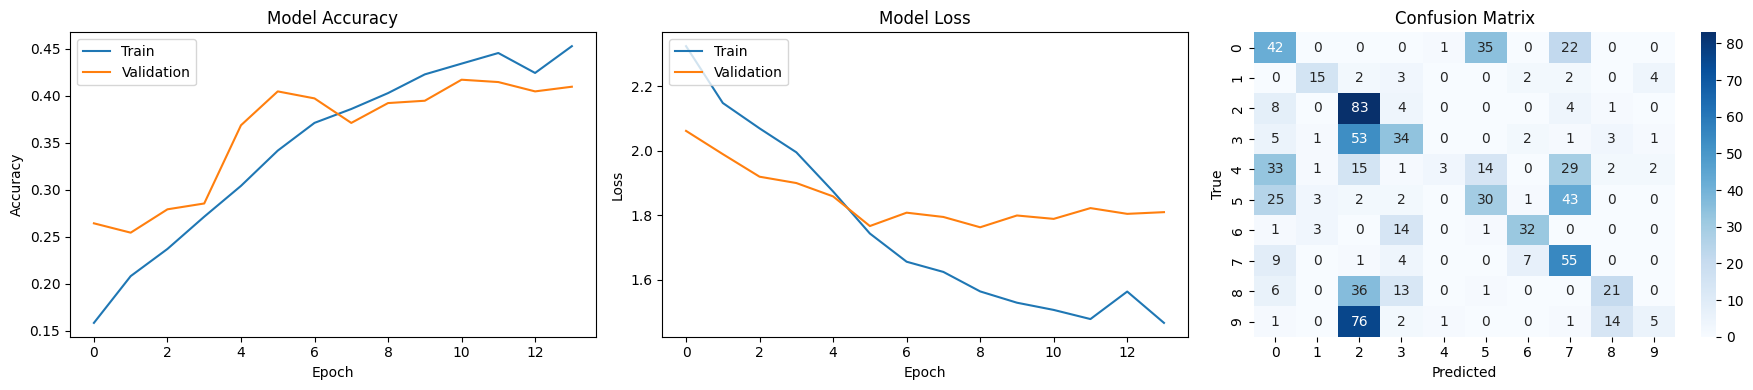

Fold 7 Test Accuracy: 0.3819


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 8...
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.1445 - loss: 2.4220 - val_accuracy: 0.1973 - val_loss: 2.1571
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.2106 - loss: 2.1696 - val_accuracy: 0.2206 - val_loss: 2.1153
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.2409 - loss: 2.0771 - val_accuracy: 0.2904 - val_loss: 1.9958
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.2839 - loss: 1.9783 - val_accuracy: 0.2770 - val_loss: 1.9415
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.2827 - loss: 1.9177 - val_accuracy: 0.2892 - val_loss: 1.8455
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.3455 - loss: 1.7067 - val_accuracy: 0.3395 - val_loss: 1.6924
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.3665 - loss: 1.6546 - val_accuracy: 0.3186 - val_loss: 1.7790
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.38

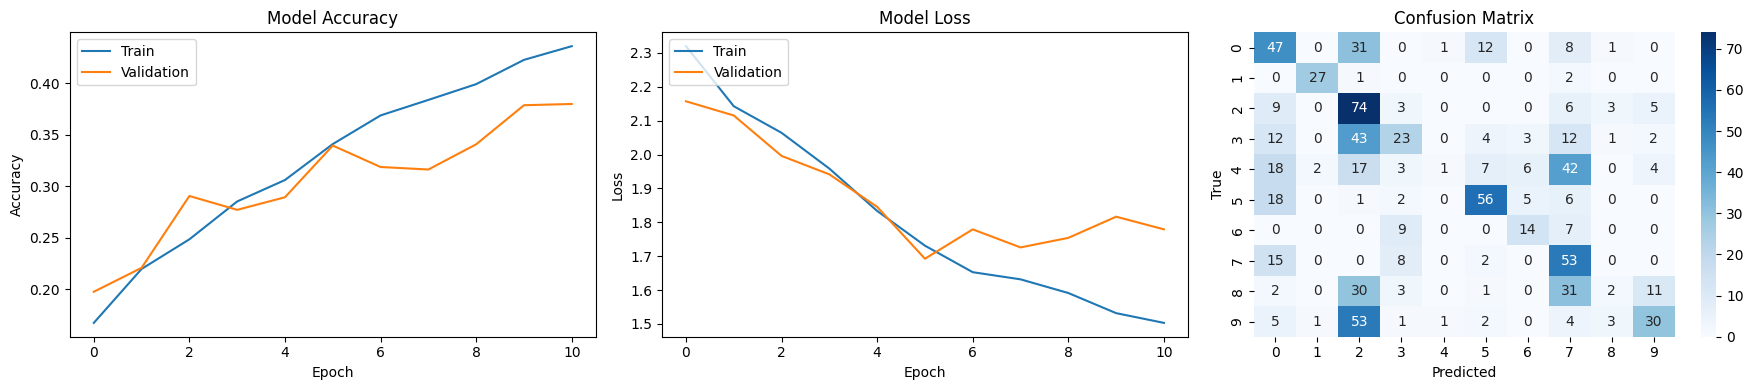

Fold 8 Test Accuracy: 0.4057


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 9...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.1463 - loss: 2.4308 - val_accuracy: 0.1876 - val_loss: 2.1593
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.2171 - loss: 2.1656 - val_accuracy: 0.1816 - val_loss: 2.1182
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.2473 - loss: 2.0697 - val_accuracy: 0.2473 - val_loss: 2.0237
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.2871 - loss: 1.9813 - val_accuracy: 0.2927 - val_loss: 1.8501
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.3174 - loss: 1.8479 - val_accuracy: 0.3142 - val_loss: 1.7307
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.3483 - loss: 1.7380 - val_accuracy: 0.3381 - val_loss: 1.6756
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.3785 - loss: 1.6697 - val_accuracy: 0.3393 - val_loss: 1.7938
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.35

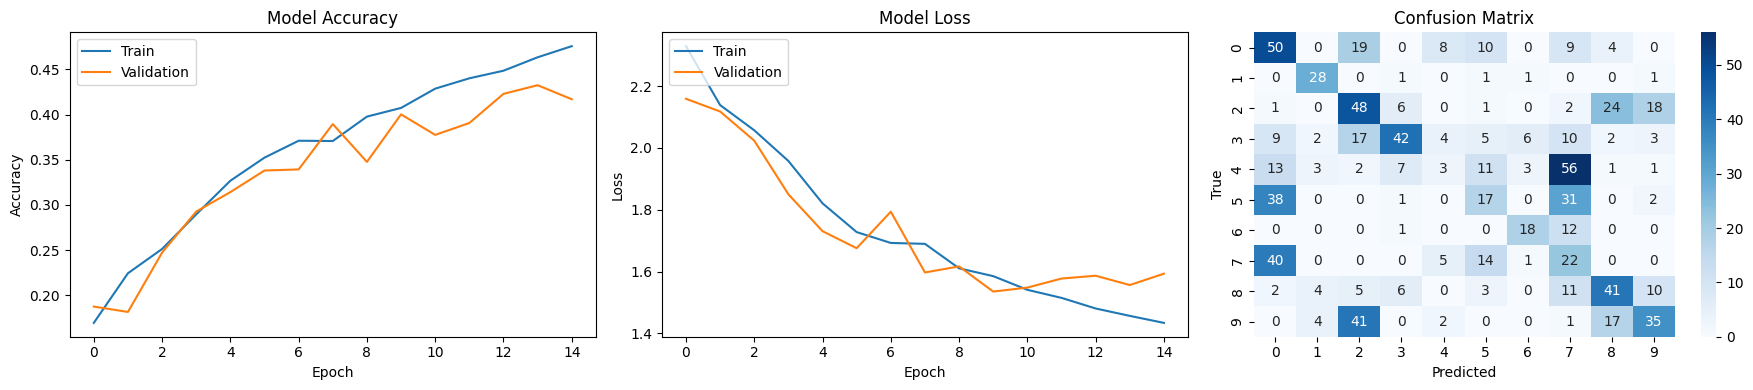

Fold 9 Test Accuracy: 0.3725


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 10...
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.1397 - loss: 2.4085 - val_accuracy: 0.2612 - val_loss: 2.0775
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.1978 - loss: 2.1815 - val_accuracy: 0.2680 - val_loss: 2.0711
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.2204 - loss: 2.1072 - val_accuracy: 0.2944 - val_loss: 2.0225
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.2590 - loss: 2.0371 - val_accuracy: 0.3150 - val_loss: 1.9489
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.2905 - loss: 1.9711 - val_accuracy: 0.3814 - val_loss: 1.8840
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.3139 - loss: 1.9058 - val_accuracy: 0.3711 - val_loss: 1.6718
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.3472 - loss: 1.7649 - val_accuracy: 0.3448 - val_loss: 1.7405
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.3

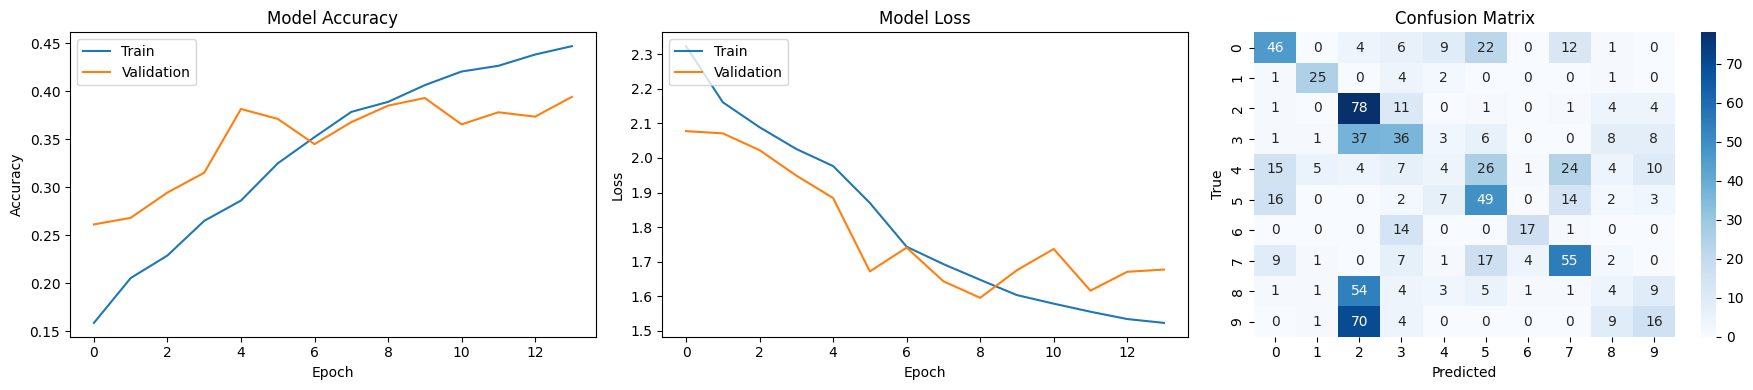

Fold 10 Test Accuracy: 0.3943

Average Accuracy across 10 folds: 39.4586%
Standard Deviation: 1.7751%


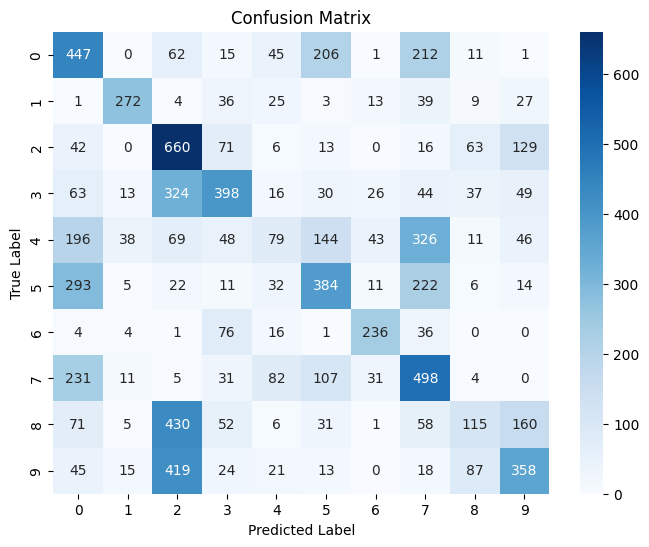

In [26]:
num_folds = 10
fold_accuracies = []
early_stoppings=[]
for i in range(num_folds):
    early_stoppings.append(EarlyStopping(
        monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
        patience=5 ,          # Number of epochs to wait after no improvement
        restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
        verbose=1            # Print messages when early stopping is triggered
    ))
    
y_test_multiclasses = []
predicted_labels_rnns = []
class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(num_folds):
    if i == i:
        # Define the test and validation indices
        test_idx = i
        val_idx = (i + 1) % num_folds
        
        # Split the data accordingly
        X_test = X_folds[test_idx]
        y_test = y_folds[test_idx]
        X_val = X_folds[val_idx]
        y_val = y_folds[val_idx]

        # Combine the remaining folds for training
        X_train = np.concatenate([X_folds_aug[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)
        y_train = np.concatenate([y_folds_aug[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)

        # Create a new model instance for each fold
        model = create_vanilla_rnn_model()
        
        # Train the model
        print(f"\nTraining fold {i + 1}...")
        history=model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stoppings[i]])
        model.save(f"model_fold{i}.keras")

        predictions_rnn = model.predict(X_test)
        predicted_labels_rnn = np.argmax(predictions_rnn, axis=1)

        y_test_multiclass = np.argmax(y_test, axis=1)
        
        if i==0:
            y_test_multiclasses = y_test_multiclass
            predicted_labels_rnns = predicted_labels_rnn
        else:
            y_test_multiclasses = np.concatenate((y_test_multiclasses, y_test_multiclass))
            predicted_labels_rnns = np.concatenate((predicted_labels_rnns, predicted_labels_rnn))

        plot_graphs(history, y_test_multiclass, predicted_labels_rnn, class_labels=class_labels)

        # Evaluate on the test set
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Fold {i + 1} Test Accuracy: {test_acc:.4f}")
        
        # Save the accuracy for later analysis
        fold_accuracies.append(test_acc)

average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across {num_folds} folds: {average_accuracy*100:.4f}%")
print(f"Standard Deviation: {np.std(fold_accuracies)*100:.4f}%")

# Print average accuracy across all folds
cm = confusion_matrix(y_test_multiclasses, predicted_labels_rnns)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Results Comparison

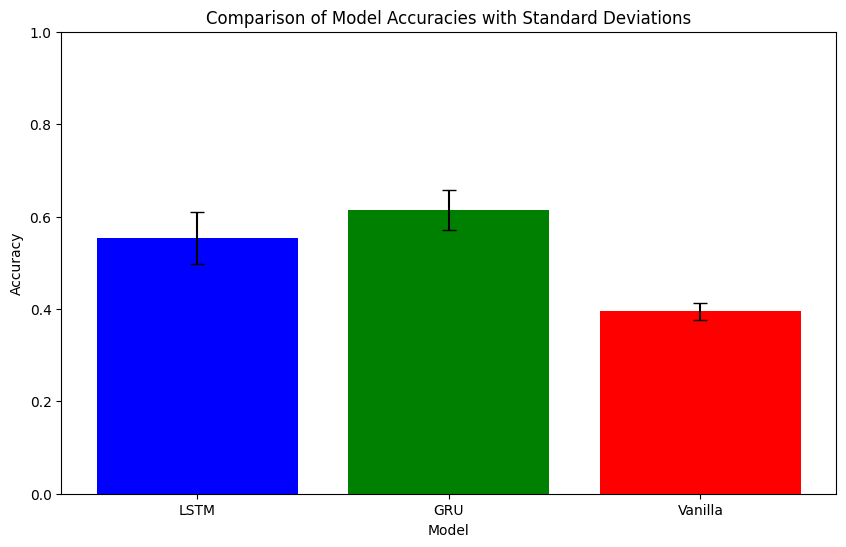

In [27]:
# Define the accuracies of the three final models
LSTM_accuracy = 0.553926 # Assuming fold_accuracies contains the accuracies for CNN 1D
GRU_accuracy = 0.614703  # Assuming fold_accuracies contains the accuracies for CNN 2D Mel
Vanilla_accuracy = 0.394586  # Assuming fold_accuracies contains the accuracies for CNN 2D MFCC

# Create a bar plot to compare the accuracies
model_names = ['LSTM', 'GRU', 'Vanilla']
accuracies = [LSTM_accuracy, GRU_accuracy, Vanilla_accuracy]
# Define the standard deviations for each model
std_devs = [0.055635, 0.043306, 0.017751]

# Create a bar plot with error bars to show the standard deviations
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, yerr=std_devs, capsize=5, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies with Standard Deviations')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()

### Conclusion

Based on the results obtained from our experiments with different Recurrent Neural Network (CNN) architectures, we can draw the following conclusions:

1. **Model Performance**:
    - The **Vanilla RNN** achieved the lowest accuracy of 39.46%. This reflects its limitations in handling long-term dependencies.
    - The **GRU** model achieved the highest accuracy of 61.47%, outperforming both the LSTM and Vanilla RNN. This indicates that GRUs are better suited to this problem, likely due to their simpler structure and efficient handling of temporal dependencies.
    - The **LSTM** model achieved an accuracy of 55.39%. While it performed better than the Vanilla RNN, it fell short of the GRU in accuracy, suggesting that while effective, LSTM may not be the optimal choice for this specific task.

2. **Standard Deviations**:
    - The standard deviations for the accuracies of the models were as follows:
      - **Vanilla RNN**: 0.0178
      - **GRU**: 0.0433
      - **LSTM**: 0.0556
    - The relatively low standard deviations indicate that the models' performances were consistent across different folds of the dataset.

In summary, the Vanilla RNN performed the worst due to its limitations in handling long-term dependencies effectively. GRU outperformed LSTM, showing better generalization for this specific problem. However, focusing on LSTM-based models revealed that bidirectional LSTMs were more suited for this task, as they leveraged both past and future context, resulting in improved accuracy.

We also demonstrated that data augmentation techniques significantly enhanced model performance by introducing diversity and improving generalization. Additionally, this project highlighted the trade-off between model complexity and reducing overfitting. While increasing model capacity, such as adding bidirectional layers or more units, improved performance, it also required careful regularization to prevent overfitting.

Finally, our study faced limitations in computational power, restricting our ability to exhaustively experiment with every detail and configuration. This suggests that while our models show promising results, there remains potential for further improvement with more extensive hyperparameter tuning or advanced techniques. Overall, this project underlines the importance of model selection, data augmentation, and the balance between complexity and generalization in building robust RNN-based solutions for sequential tasks.

### References

- Salamon, J., Jacoby, C., & Bello, J. P. (2014). A dataset and taxonomy for urban sound research. ACM International Conference Proceeding Series.

- Kim, S., & Lee, S.-P. (2023). A BiLSTM–Transformer and 2D CNN architecture for emotion recognition from speech. Electronics, 12(4034).

- Wilkinson, N., & Niesler, T. (2021). A hybrid CNN-BiLSTM voice activity detector.